In [2]:
import os
# import h5py
from util.misc import saveraster
from j_output.user_output import TmrtOutput
# from j_dataprep import DEMs

from collections import defaultdict
# from j_dataprep.landcover import LandCover
from osgeo import gdal
# from j_dataprep.DEMs import Buildings
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import pandas as pd

# for average heat day no trees

In [3]:
bbox_dict = {
        'historisch': [(175905, 317210, 176505, 317810), (84050, 447180, 84650, 447780), (80780, 454550, 81380, 455150),
                       (233400, 581500, 234000, 582100), (136600, 455850, 137200, 456450),
                       (121500, 487000, 122100, 487600)
                       ],
        'tuindorp': [(76800, 455000, 78200, 455700), (152600, 463250, 153900, 463800), (139140, 469570, 139860, 470400),
                     (190850, 441790, 191750, 442540), (113100, 551600, 113650, 552000), (32050, 391900, 32850, 392500)

                     ],
        'vinex': [(146100, 486500, 147000, 487400), (153750, 467550, 154650, 468450), (115300, 517400, 116100, 518250),
                  (102000, 475900, 103100, 476800), (160750, 388450, 161650, 389350), (84350, 449800, 85250, 450700)

                  ],
        'volkswijk': [(104200, 490550, 105100, 491450), (78200, 453900, 79100, 454800), (83500, 447020, 84050, 447900),
                      (136200, 456500, 137100, 457300), (182700, 579200, 183800, 579750),
                      (233400, 582800, 234300, 583700)

                      ],
        'bloemkool': [(81700, 427490, 82700, 428200), (84050, 444000, 84950, 444900), (116650, 518700, 117550, 519600),
                      (235050, 584950, 235950, 585850), (210500, 473900, 211400, 474800),
                      (154700, 381450, 155700, 382150)

                      ],

        'stedelijk': [
            (90300, 436900, 91300, 437600), (91200, 438500, 92100, 439300), (121350, 483750, 122250, 484650),
            (118400, 486400, 119340, 487100)
        ]
}

gpkg_names = ['typos', "tuindorp", 'vinexwijk', 'volkswijk', 'bloemkoolwijk', 'stedelijk_bouwblok']

base_folder = "E:/Geomatics/thesis/_analysisfinalfurther/"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]



In [ ]:

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)
    for i in locs:
        try:
            boundingbox = bbox_dict[typ][i]
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        dtm_path = typology_path + f"/loc_{i}/final_dtm.tif"

        buildingslocation = Buildings(boundingbox)


        landcover = LandCover(boundingbox, dataset_path=dtm_path, building_data=buildingslocation.building_geometries)

        building_mask = ~landcover.building_mask
        water_mask = landcover.water_mask

        if water_mask is not None:
            total_mask = np.logical_or(building_mask, ~water_mask).astype(np.uint8)
        else:
            total_mask = building_mask.astype(np.uint8)

        dataset = gdal.Open(dtm_path)
        saveraster(dataset, typology_path + f'/loc_{i}/masks.tif', total_mask)

In [16]:
gpkg_path = "E:/Geomatics/thesis/_typos/typos.gpkg"

j = 0

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    layer_name = gpkg_names[j]
    gdf = gpd.read_file(gpkg_path, layer=layer_name)

    for i in locs:
        try:
            boundingbox = bbox_dict[typ][i]
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        dtm_path = typology_path + f"/loc_{i}/final_dtm.tif"
        with rasterio.open(dtm_path) as src:
            dtm_meta = src.meta.copy()
            transform = src.transform
            crs = src.crs
            shape = (src.height, src.width)

        dataset = gdal.Open(dtm_path)
        file = dataset.GetRasterBand(1).ReadAsArray()

        body = np.zeros_like(file)

        geom_mask = rasterize(
            [(geom, 1) for geom in gdf.geometry],
            out_shape=shape,
            transform=transform,
            fill=0,
            dtype='uint8'
        )
        new_mask = (geom_mask == 0).astype(np.uint8)

        existing_mask_gdal = gdal.Open(f'{typology_path}/loc_{i}/masks.tif')
        existing_mask = existing_mask_gdal.ReadAsArray()

        total_mask = np.logical_or(existing_mask, new_mask).astype(np.uint8)

        saveraster(dataset, typology_path + f'/loc_{i}/masks_combined.tif', total_mask)

    j += 1

Skipping stedelijk, index 4 – bounding box not found.
Skipping stedelijk, index 5 – bounding box not found.


In [15]:
import os
import pandas as pd
from osgeo import gdal

base_folder = "D:/Geomatics/thesis/_analysisfinalfurther"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]
sol = 'solweig_green_ext'


for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    for i in locs:
        try:
            _ = bbox_dict[typ][i]  # Still check if bbox exists, even if we don't store it
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        area_path = os.path.join(typology_path, f"loc_{i}", sol)
        mask_path = os.path.join(typology_path, f'loc_{i}', 'masks_combined.tif')

        if not os.path.exists(mask_path):
            print(f"Skipping {typ}, index {i} – mask not found.")
            continue

        mask_gdal = gdal.Open(mask_path)
        mask = ~mask_gdal.ReadAsArray().astype(bool)

        tmrt_processor = TmrtOutput(output_folder=area_path, building_mask=mask)

        # Specific 12:00 time
        try:
            tmrt_12 = tmrt_processor.tmrt_arrays_by_time["1200"]

        except KeyError:
            print(f"No 12:00 TMRT array for {typ} loc {i}")
        saveraster(mask_gdal, f"D:/Geomatics/thesis/_analysisfinalfurther/check/{typ}_{i}.tif", tmrt_12)

# Create DataFrame and save


Skipping stedelijk, index 4 – bounding box not found.
Skipping stedelijk, index 5 – bounding box not found.


In [11]:
import os
import pandas as pd
from osgeo import gdal

base_folder = "D:/Geomatics/thesis/_analysisfinalfurther"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]
sol = 'solweig_green_ext'

all_rows = []

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    for i in locs:
        try:
            _ = bbox_dict[typ][i]  # Still check if bbox exists, even if we don't store it
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        area_path = os.path.join(typology_path, f"loc_{i}", sol)
        mask_path = os.path.join(typology_path, f'loc_{i}', 'masks_combined.tif')

        if not os.path.exists(mask_path):
            print(f"Skipping {typ}, index {i} – mask not found.")
            continue

        mask_gdal = gdal.Open(mask_path)
        mask = ~mask_gdal.ReadAsArray().astype(bool)

        tmrt_processor = TmrtOutput(output_folder=area_path, building_mask=mask)

        # Grouped time stats
        for time_group, avg_array in tmrt_processor.averaged_tmrt.items():
            if avg_array is None:
                continue

            stats = tmrt_processor.calculate_stats_and_bins(avg_array, isTmrt=True)

            row = {
                'typology': typ,
                'location': i,
                'time': time_group,
                'mean': stats['mean'],
                'median': stats['median'],
                'min': stats['min'],
                'max': stats['max'],
            }

            for idx, bin_info in enumerate(stats['bins']):
                bin_range = f"{bin_info['range'][0]}_{bin_info['range'][1]}"
                row[f"area_m2_bin_{idx}_{bin_range}"] = bin_info['area_m2']
                row[f"percent_bin_{idx}_{bin_range}"] = bin_info['percentage']

            all_rows.append(row)

        # Specific 12:00 time
        try:
            tmrt_12 = tmrt_processor.tmrt_arrays_by_time["1200"]
            if tmrt_12 is not None:
                stats_12 = tmrt_processor.calculate_stats_and_bins(tmrt_12, isTmrt=True)

                row_12 = {
                    'typology': typ,
                    'location': i,
                    'time': "12:00",
                    'mean': stats_12['mean'],
                    'median': stats_12['median'],
                    'min': stats_12['min'],
                    'max': stats_12['max'],
                }

                for idx, bin_info in enumerate(stats_12['bins']):
                    bin_range = f"{bin_info['range'][0]}_{bin_info['range'][1]}"
                    row_12[f"area_m2_bin_{idx}_{bin_range}"] = bin_info['area_m2']
                    row_12[f"percent_bin_{idx}_{bin_range}"] = bin_info['percentage']

                all_rows.append(row_12)
        except KeyError:
            print(f"No 12:00 TMRT array for {typ} loc {i}")

# Create DataFrame and save
df = pd.DataFrame(all_rows)
output_csv_path = "outputstats/ext_tree.csv"
df.to_csv(output_csv_path, index=False)

print(f"Saved TMRT stats to: {output_csv_path}")


Skipping stedelijk, index 4 – bounding box not found.
Skipping stedelijk, index 5 – bounding box not found.
Saved TMRT stats to: outputstats/ext_tree.csv


In [4]:
df_avg_tree = pd.read_csv("outputstats/avg_tree.csv")
df_avg_notree = pd.read_csv("outputstats/avg_notree.csv")
df_ext_tree = pd.read_csv("outputstats/ext_tree.csv")
df_ext_notree = pd.read_csv("outputstats/ext_notree.csv")

for df, label in zip(
    [df_avg_tree, df_avg_notree, df_ext_tree, df_ext_notree],
    ['avg_tree', 'avg_notree', 'ext_tree', 'ext_notree']
):
    df["source"] = label

In [5]:
df_all = pd.concat([df_avg_tree, df_avg_notree, df_ext_tree, df_ext_notree], ignore_index=True)
df_all['without_trees'] = df_all['source'].str.contains('notree')
df_all['avg_or_ext'] = df_all['source'].str.extract(r'^(avg|ext)')

In [6]:
print(df_all)

       typology  location       time       mean     median        min  \
0    historisch         0    morning  32.849690  33.410294  21.554369   
1    historisch         0  afternoon  52.052610  54.310863  27.980782   
2    historisch         0    evening  32.920800  29.211708  26.340084   
3    historisch         0      12:00  52.436450  56.781250  27.695044   
4    historisch         1    morning  32.501550  33.119663  21.470652   
..          ...       ...        ...        ...        ...        ...   
539   stedelijk         2      12:00  62.769985  66.825370  33.777508   
540   stedelijk         3    morning  42.252464  43.743793  26.888145   
541   stedelijk         3  afternoon  61.926613  63.177876  35.296463   
542   stedelijk         3    evening  41.390260  38.298210  33.912075   
543   stedelijk         3      12:00  63.899185  66.905500  33.774803   

           max  area_m2_bin_0_-inf_15.0  percent_bin_0_-inf_15.0  \
0    42.408382                      0.0                

In [8]:
df_all = df_all[df_all['time'] != '12:00']

Saved plot as plots/mean_comparison_plot_morning_avg.png
Saved plot as plots/median_comparison_plot_morning_avg.png
Saved plot as plots/min_comparison_plot_morning_avg.png
Saved plot as plots/max_comparison_plot_morning_avg.png
Saved plot as plots/mean_comparison_plot_afternoon_avg.png
Saved plot as plots/median_comparison_plot_afternoon_avg.png
Saved plot as plots/min_comparison_plot_afternoon_avg.png
Saved plot as plots/max_comparison_plot_afternoon_avg.png
Saved plot as plots/mean_comparison_plot_evening_avg.png
Saved plot as plots/median_comparison_plot_evening_avg.png
Saved plot as plots/min_comparison_plot_evening_avg.png
Saved plot as plots/max_comparison_plot_evening_avg.png


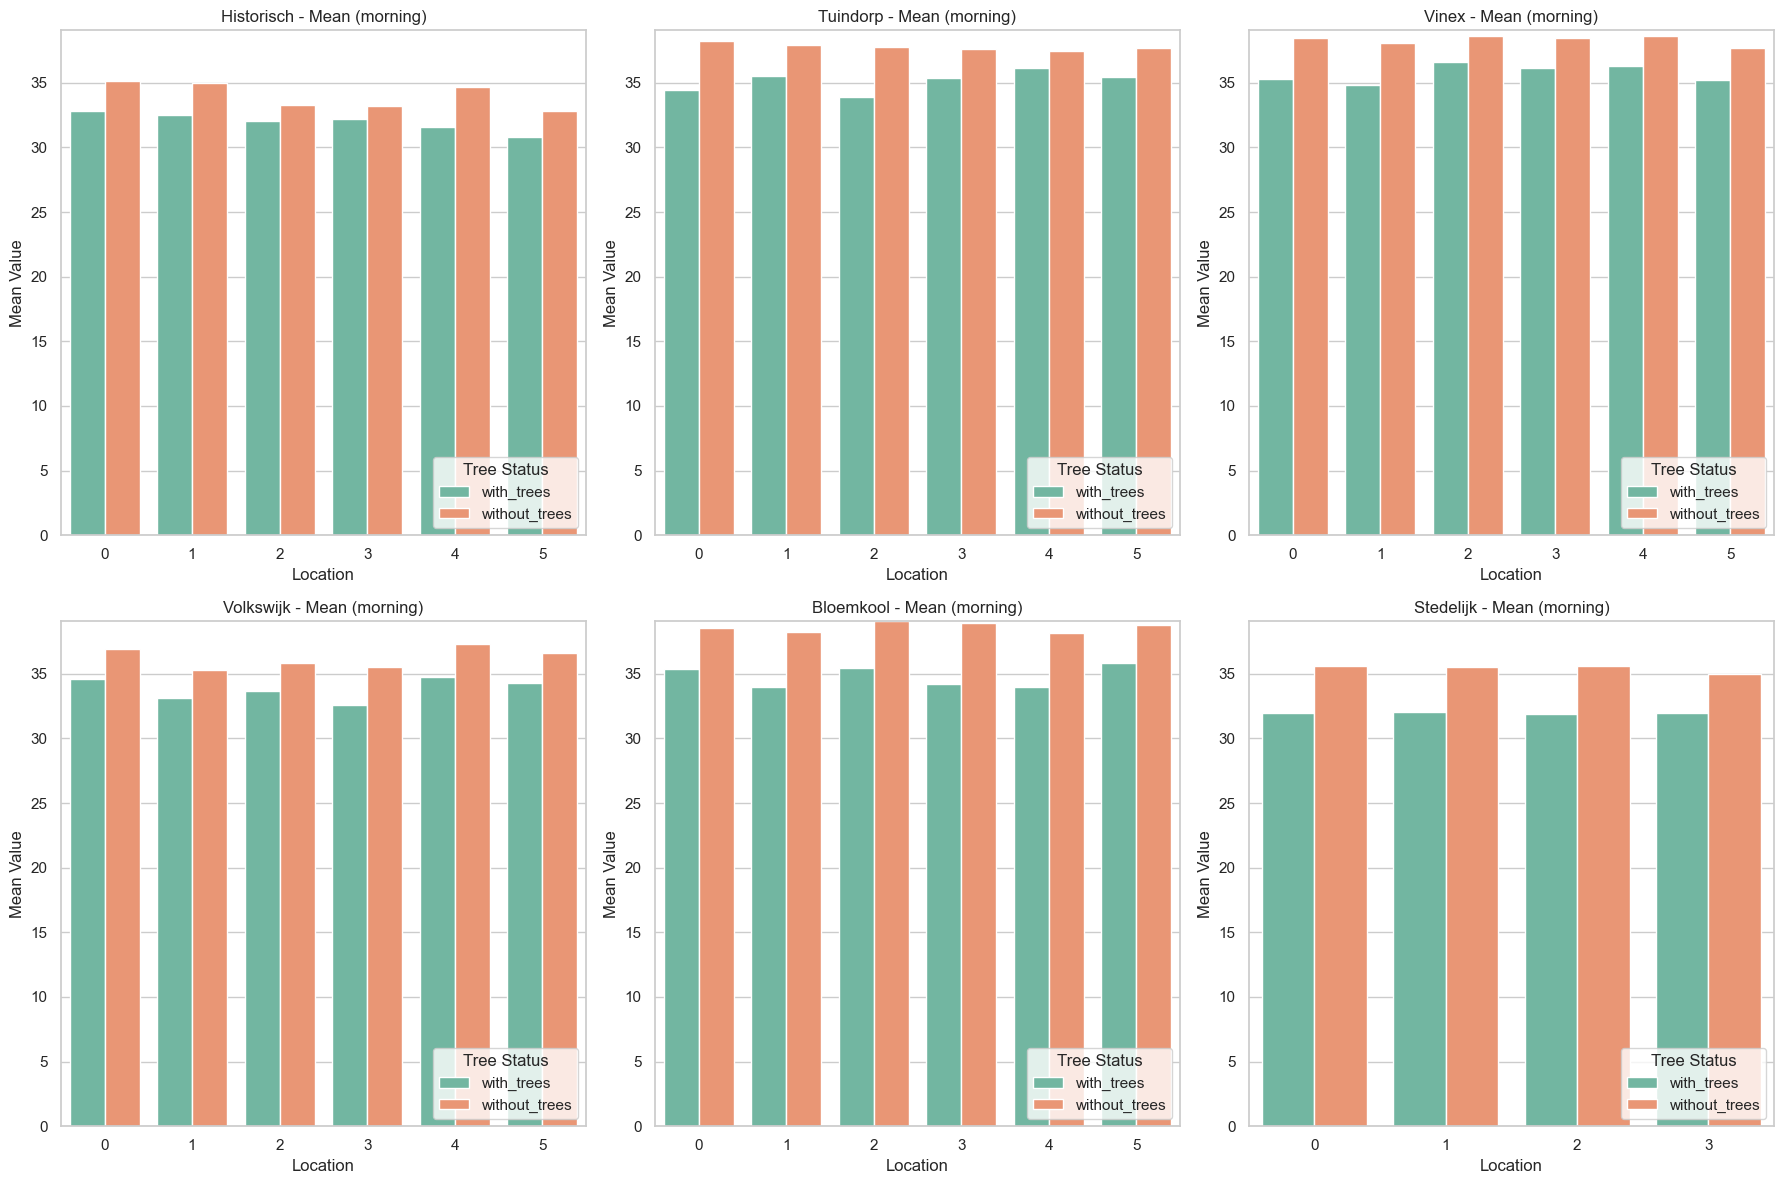

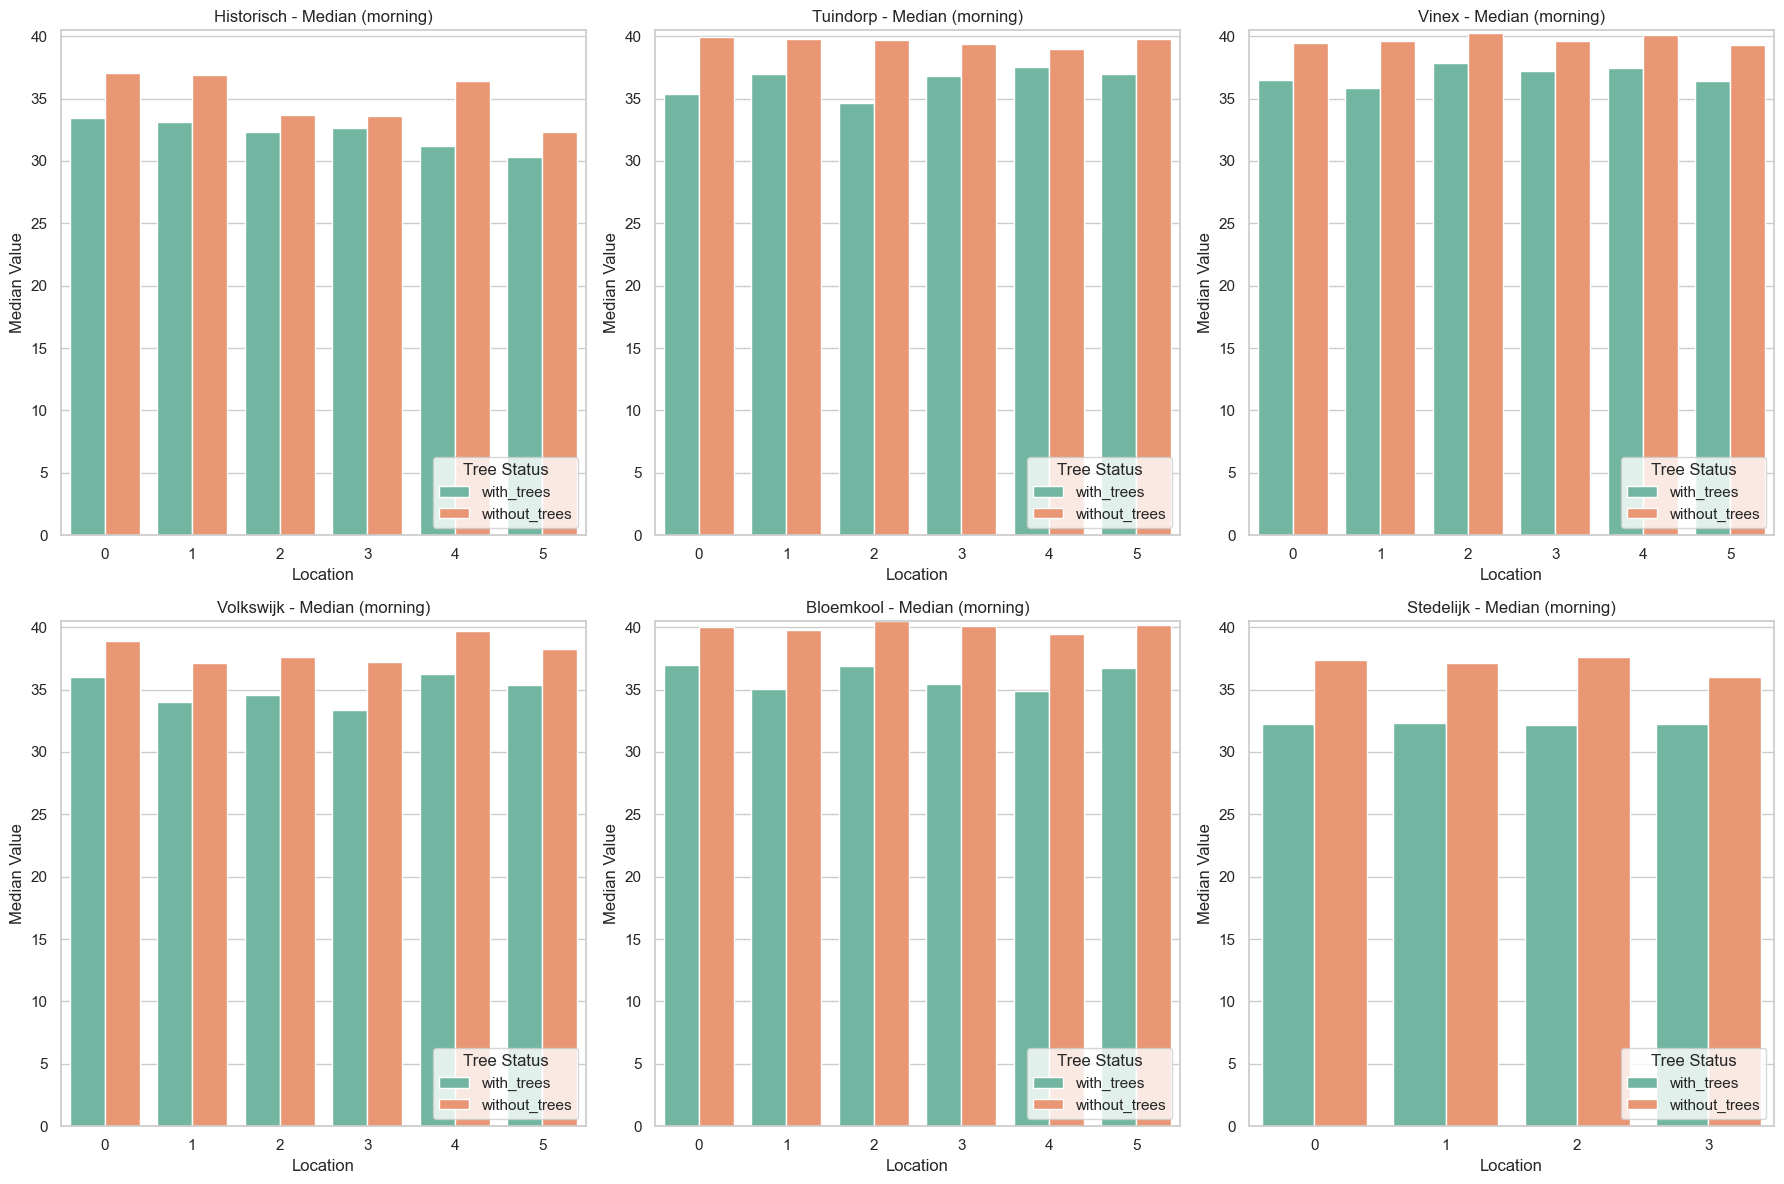

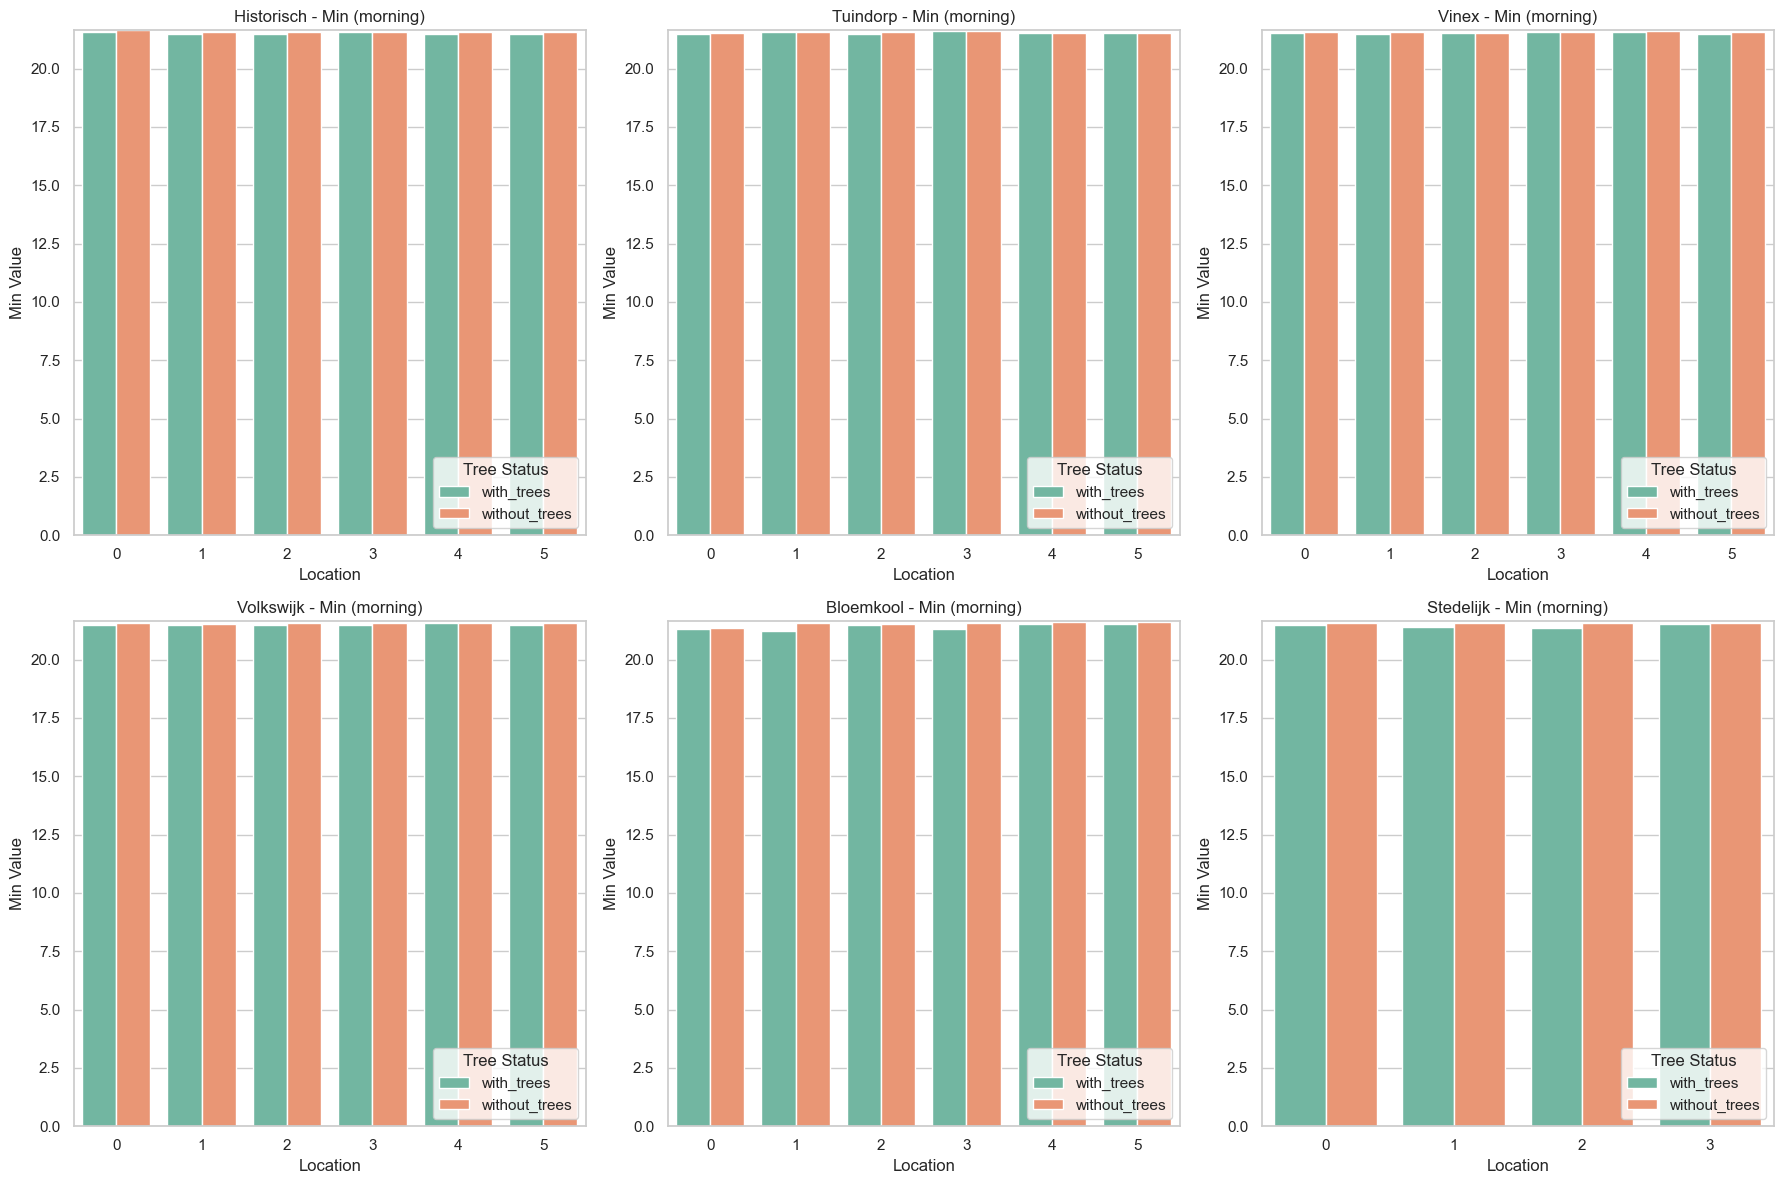

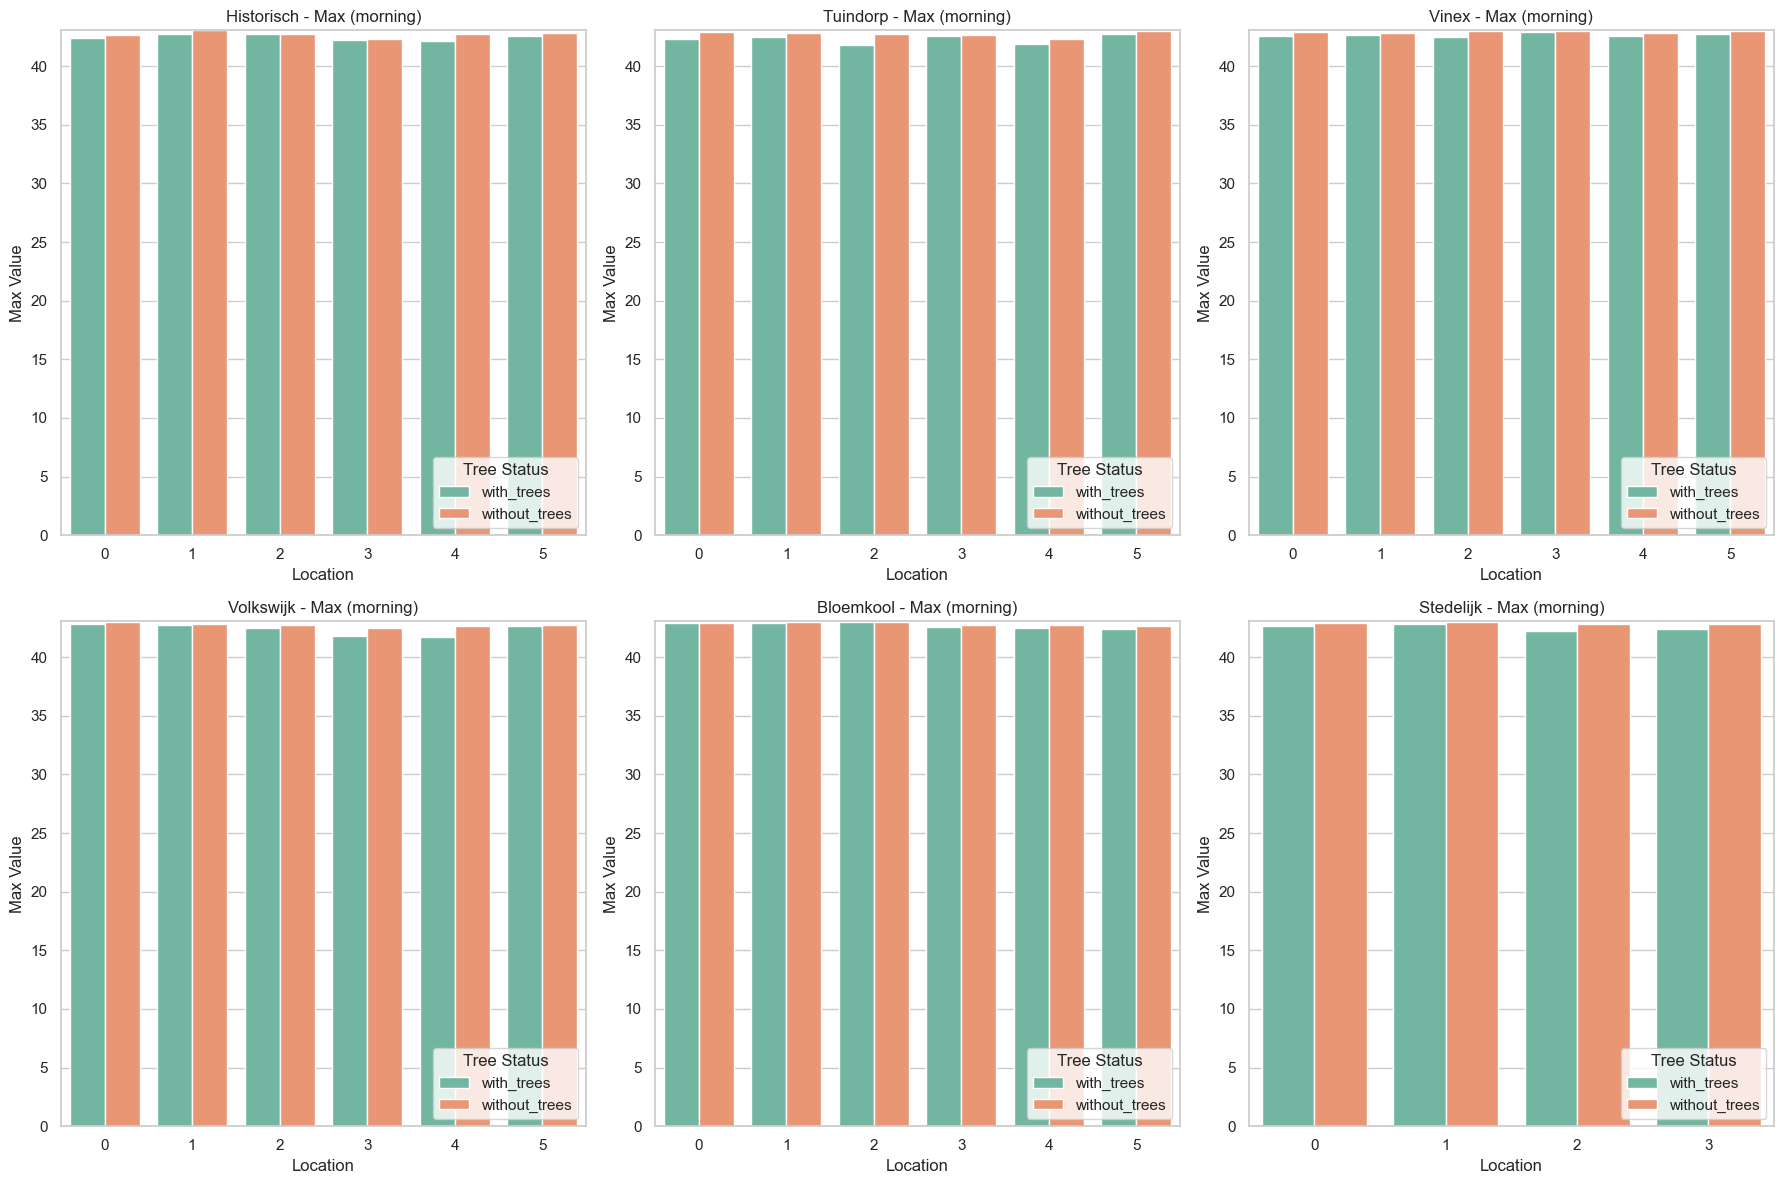

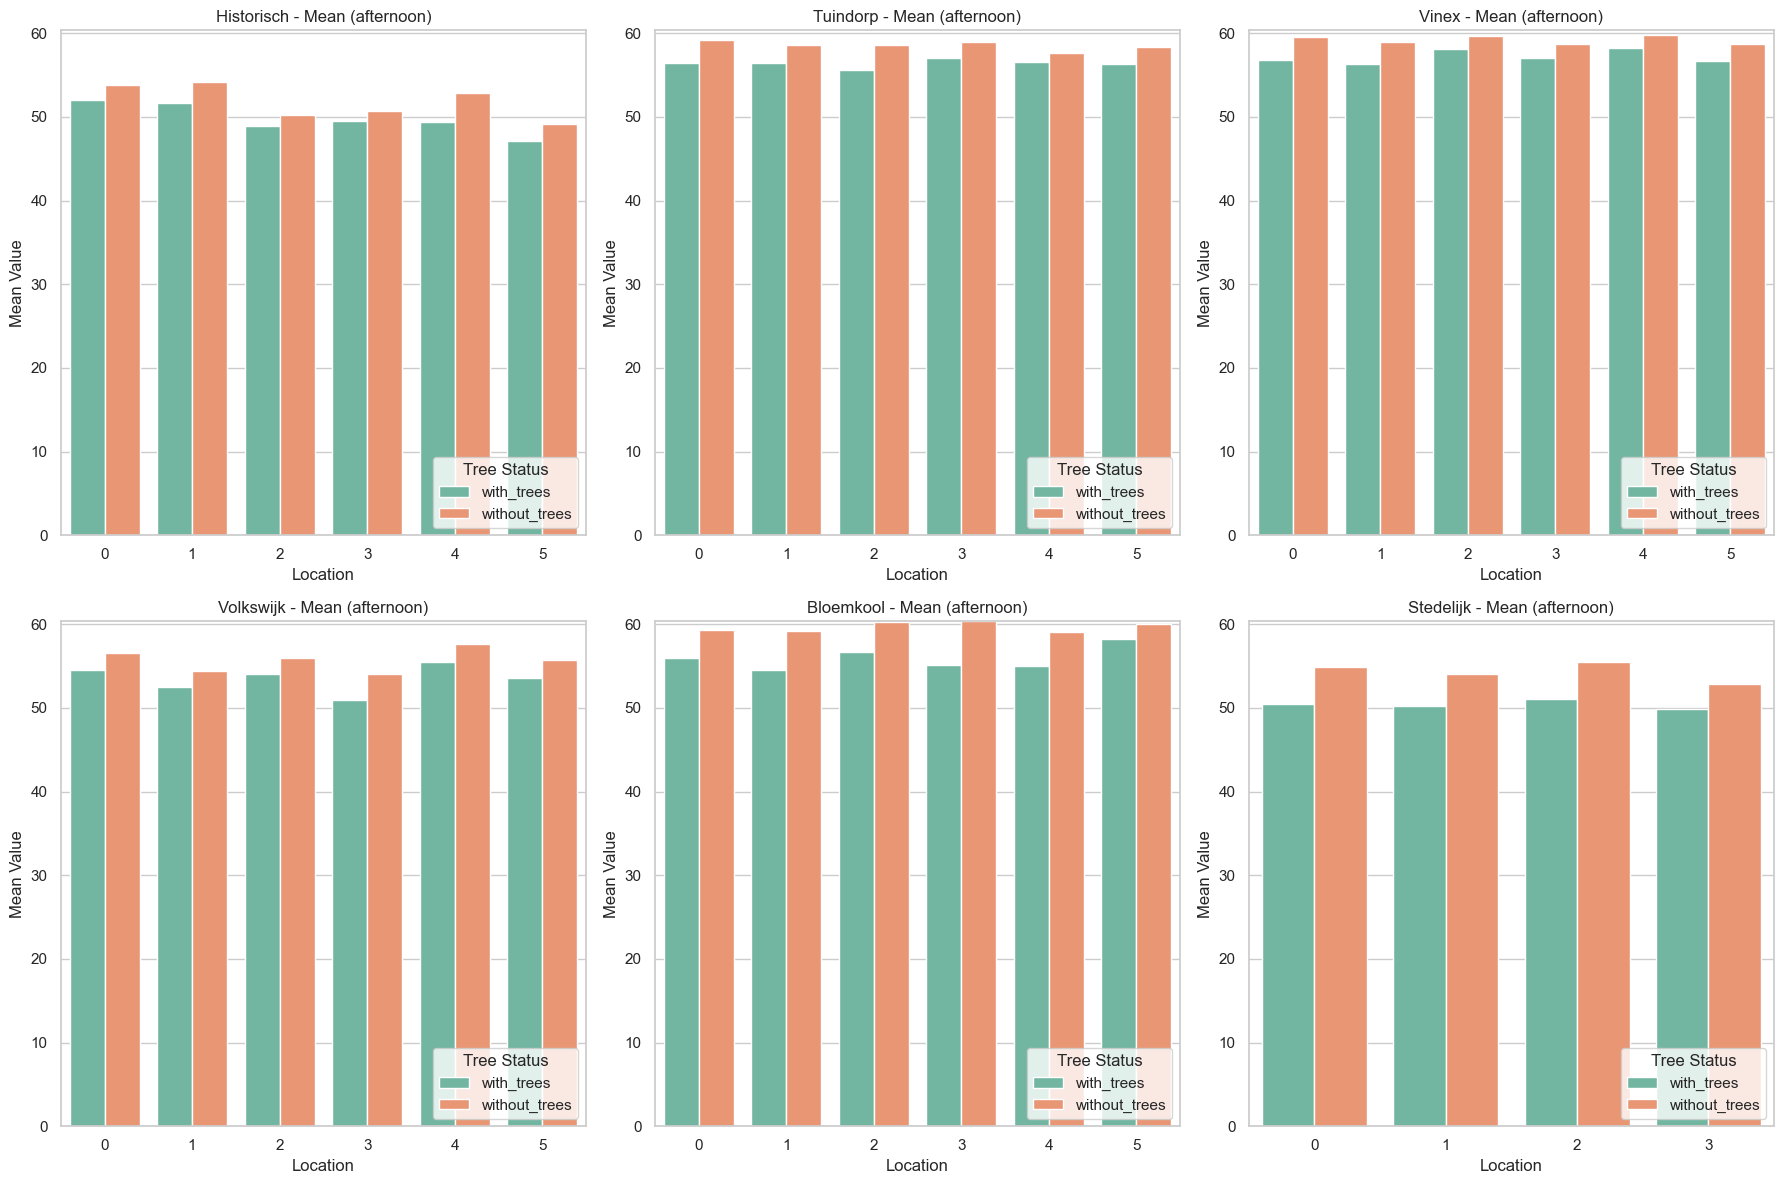

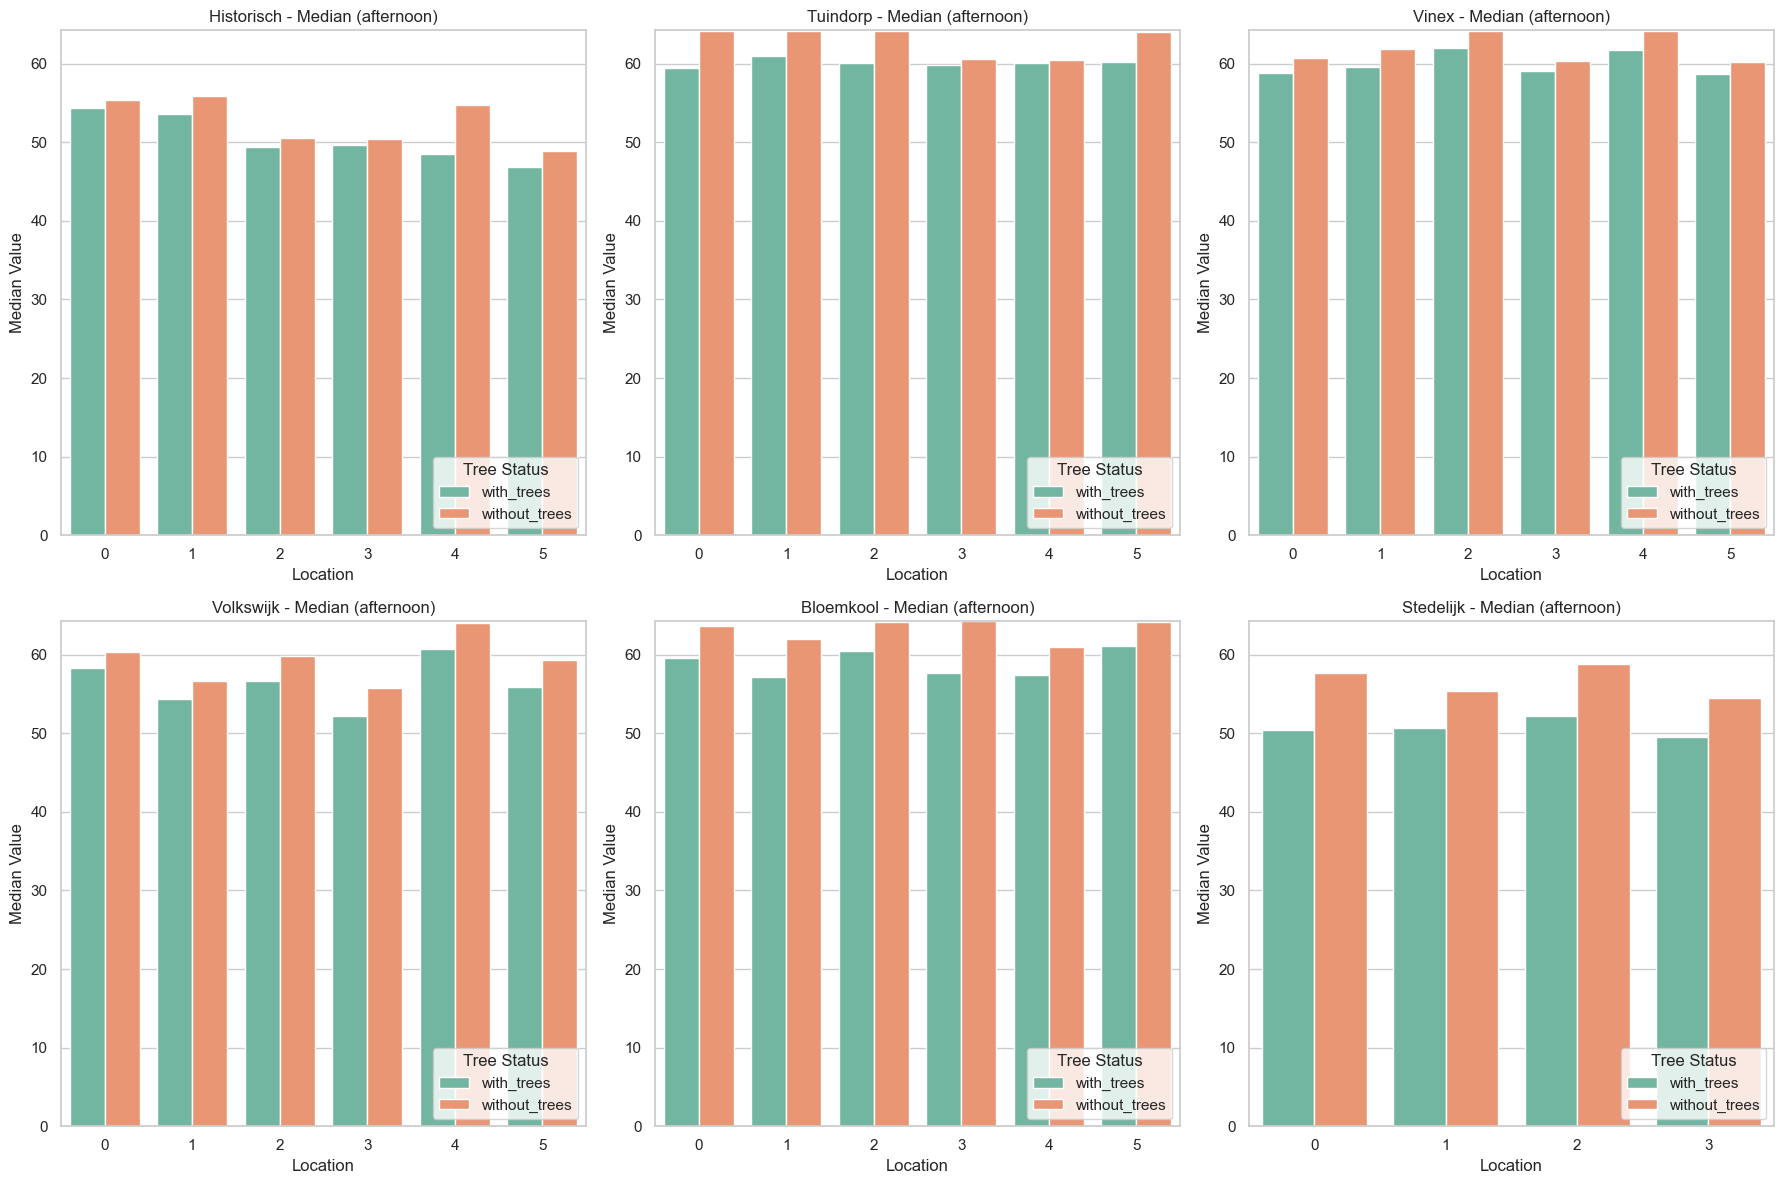

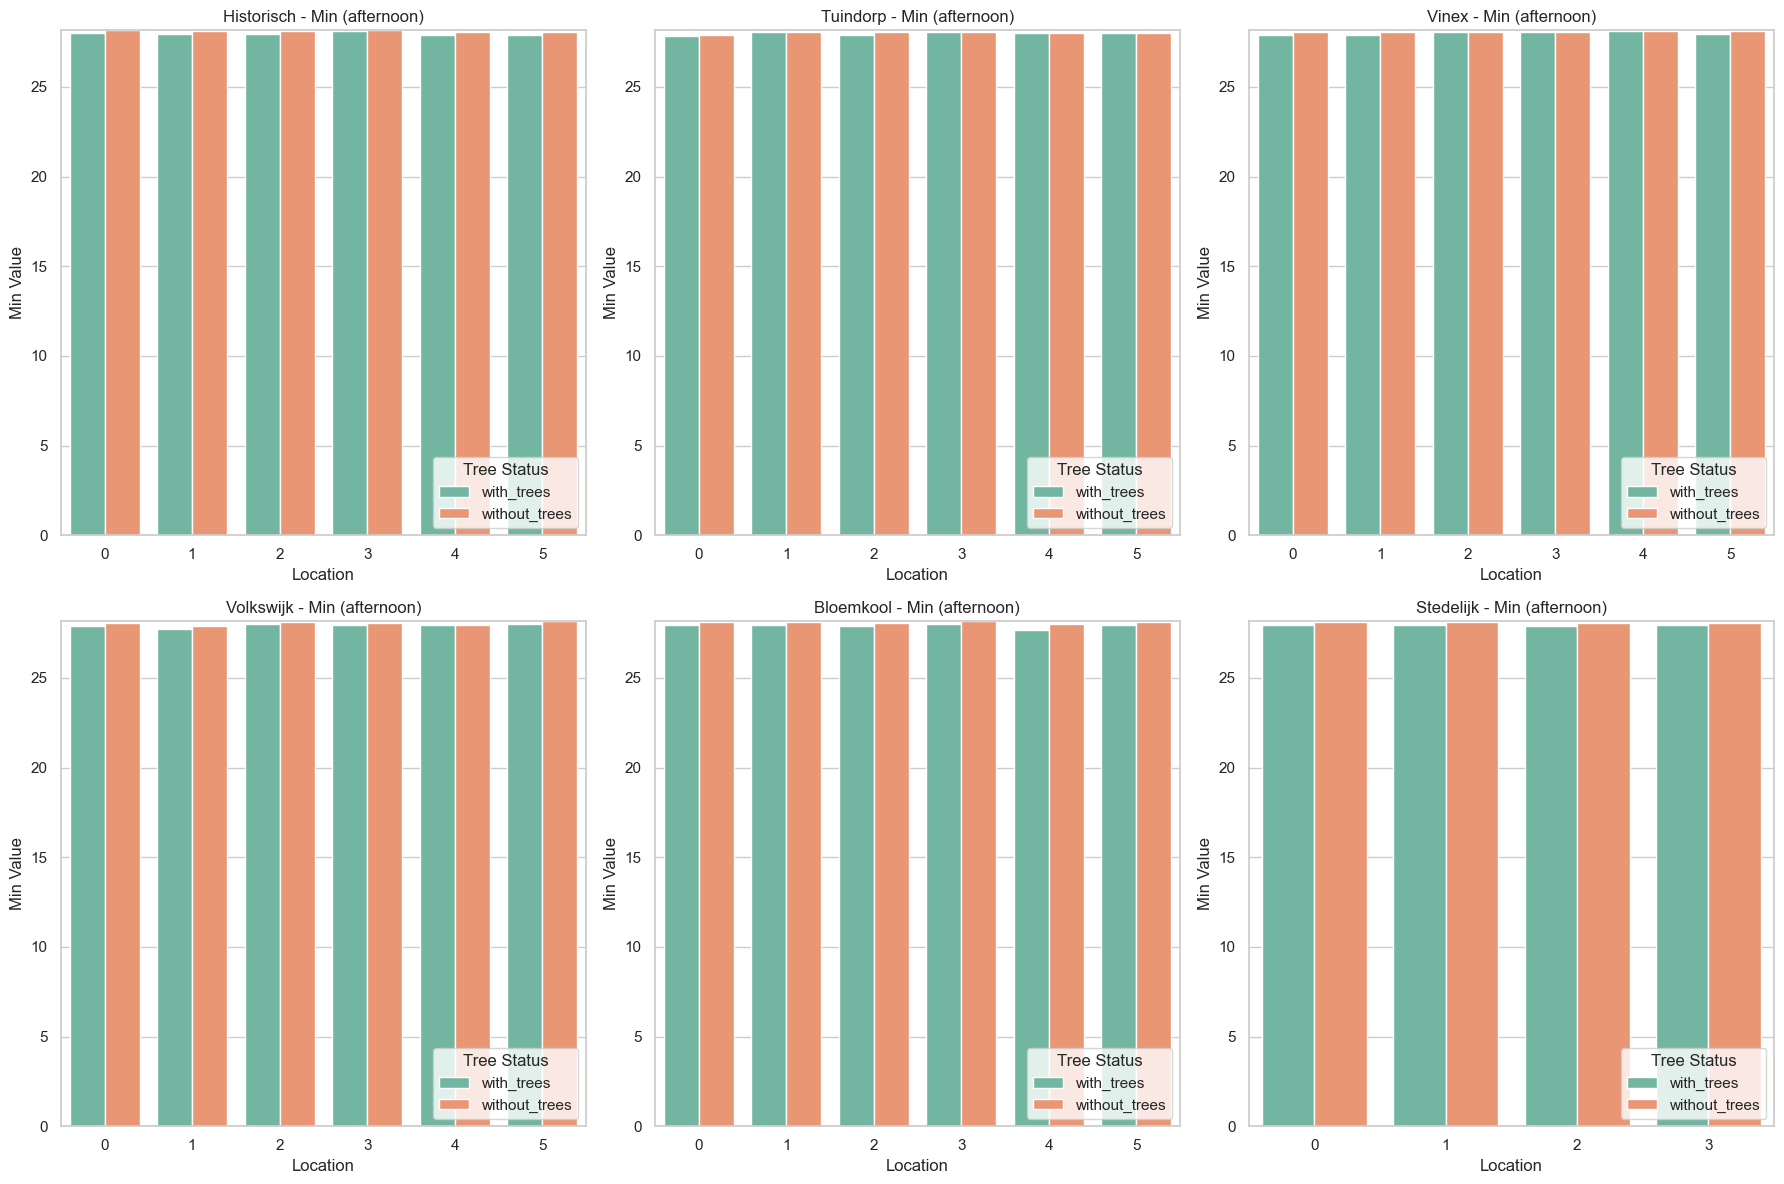

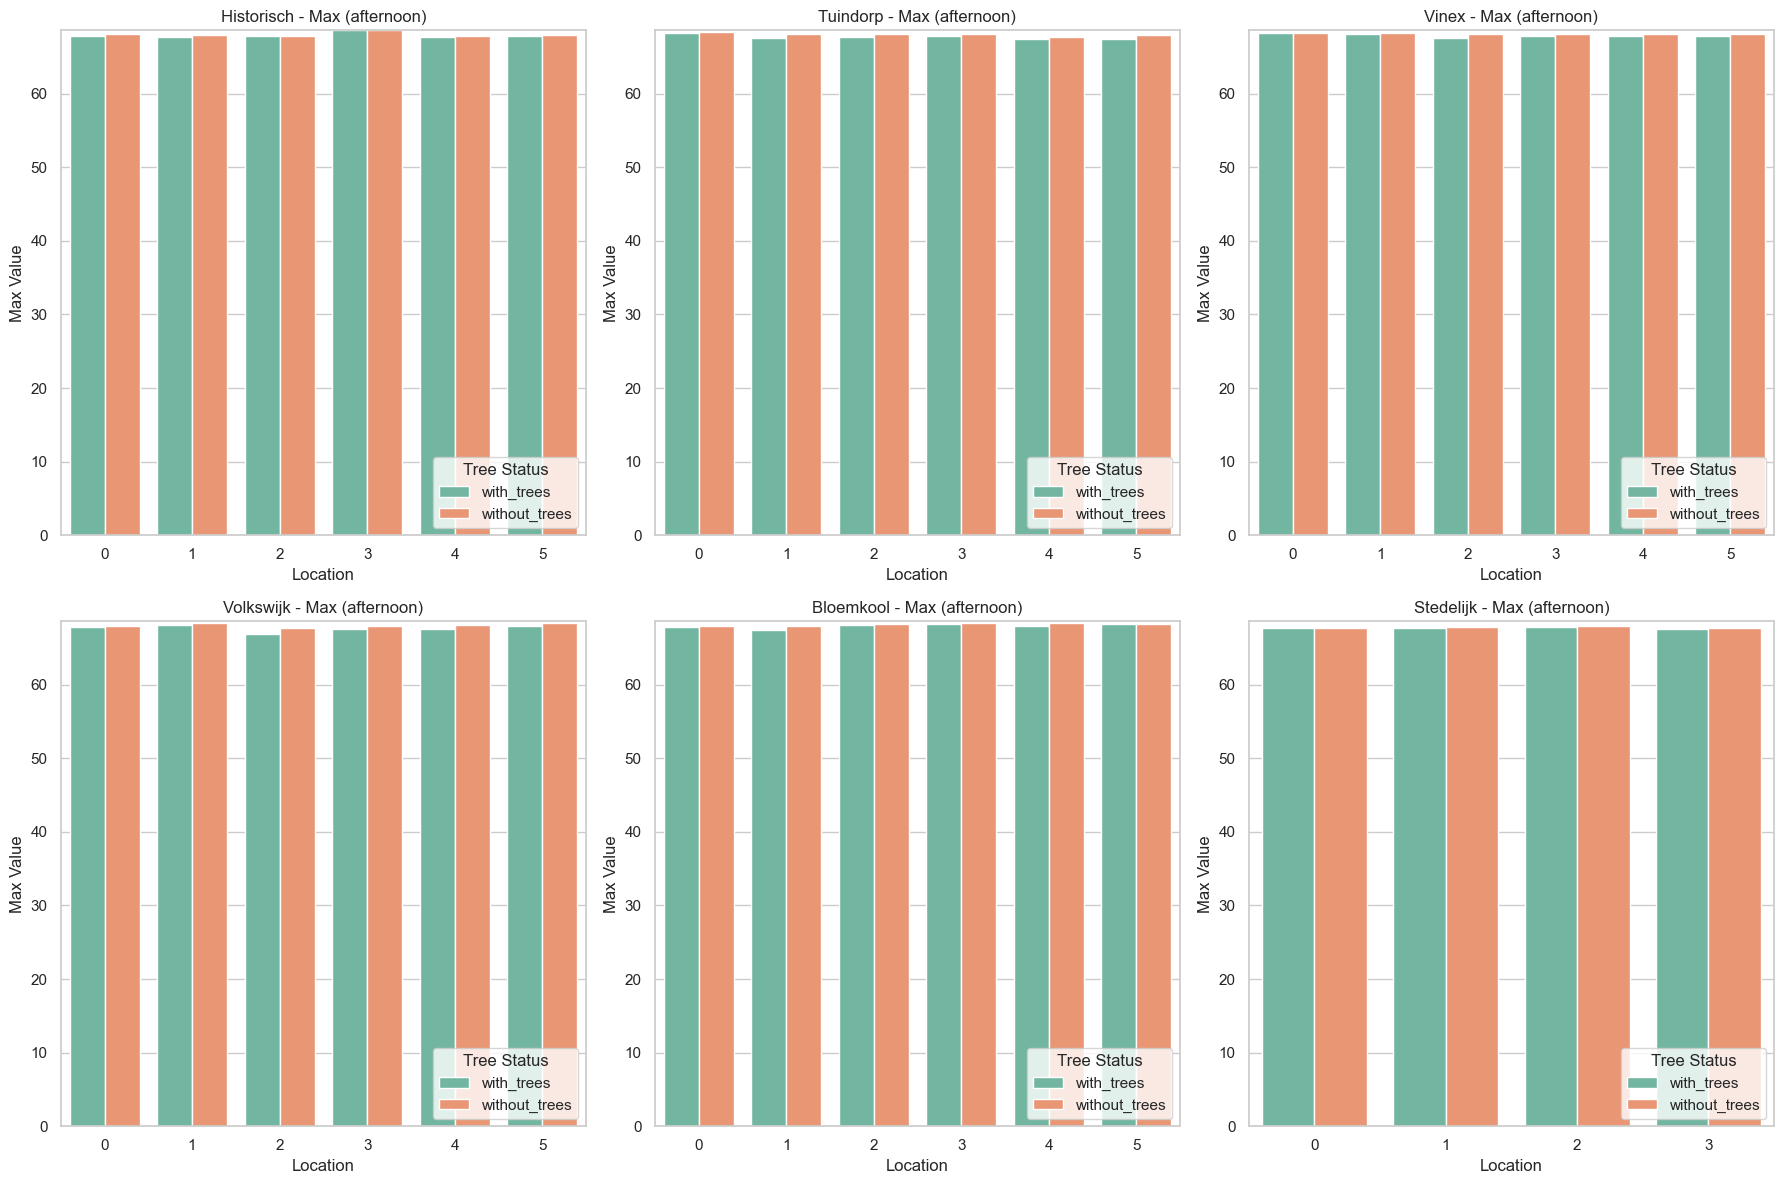

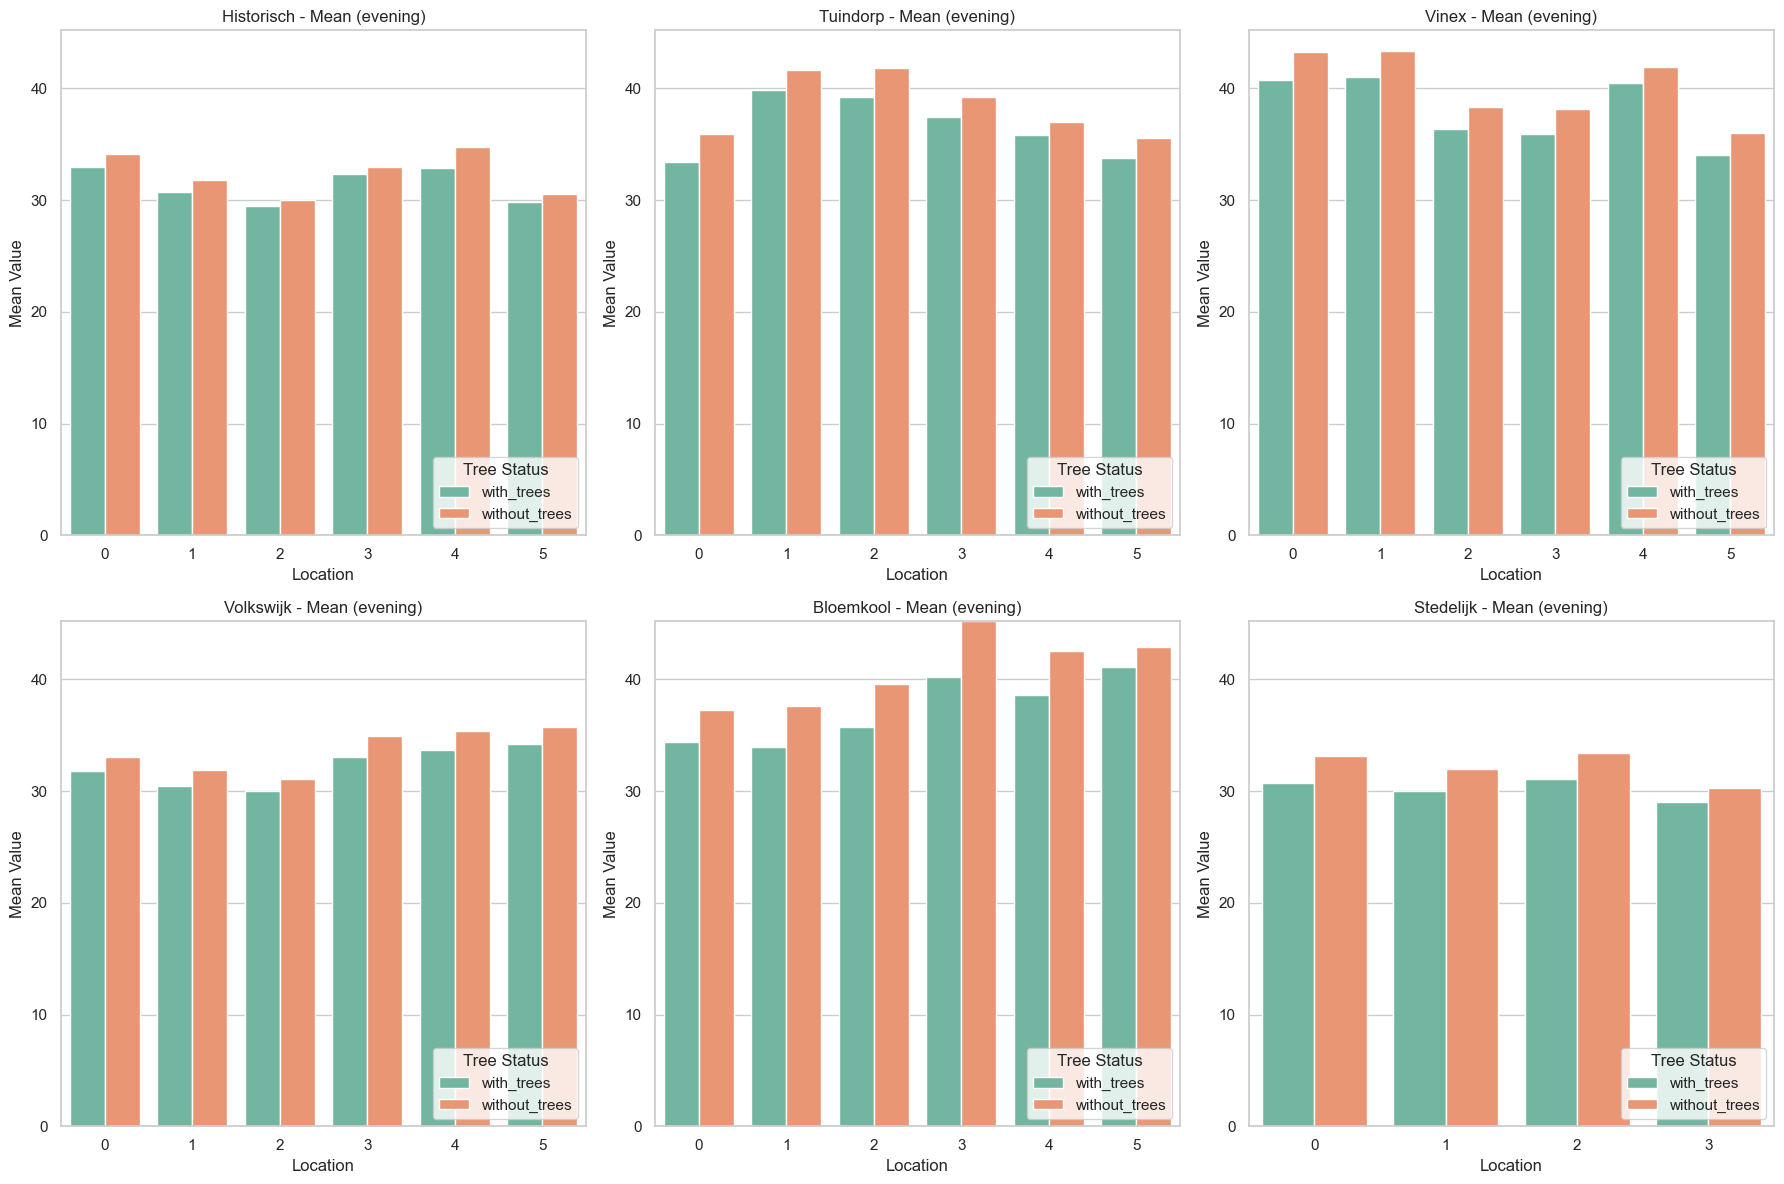

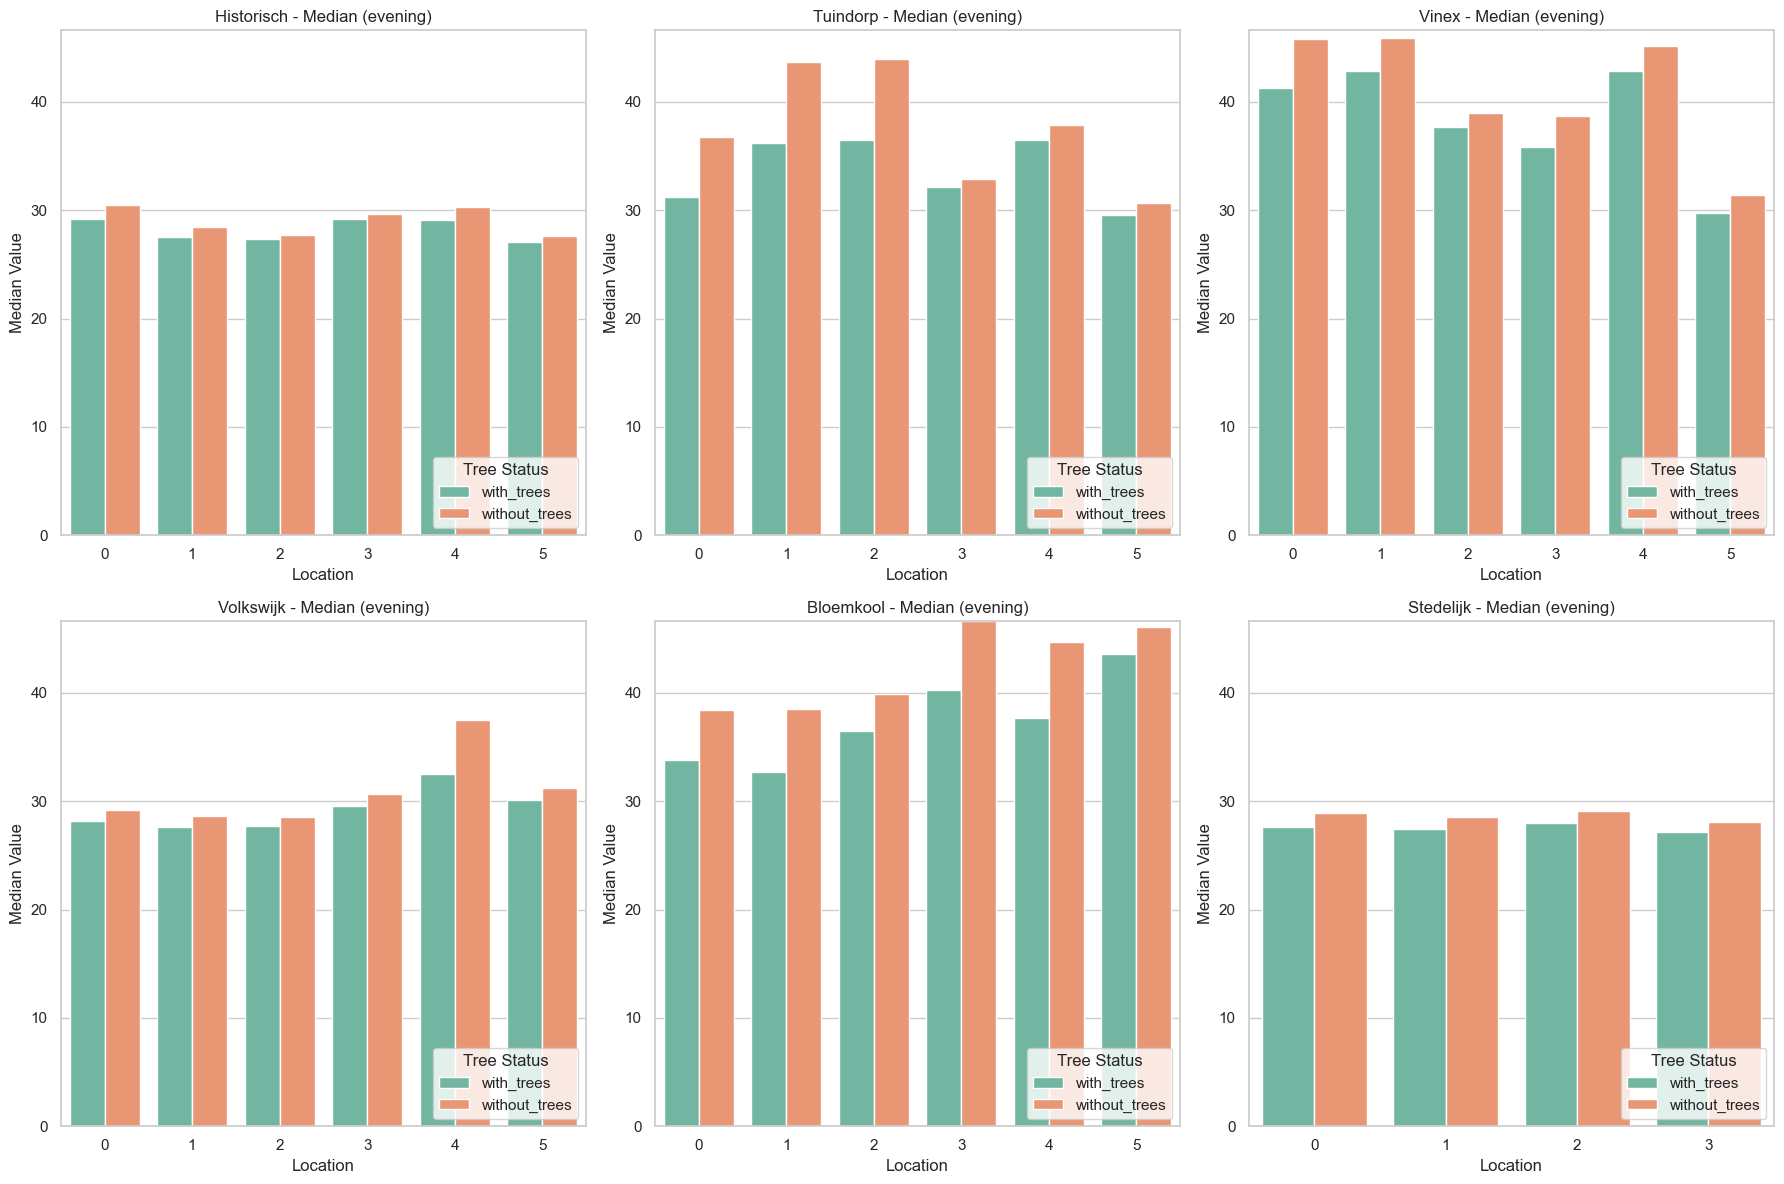

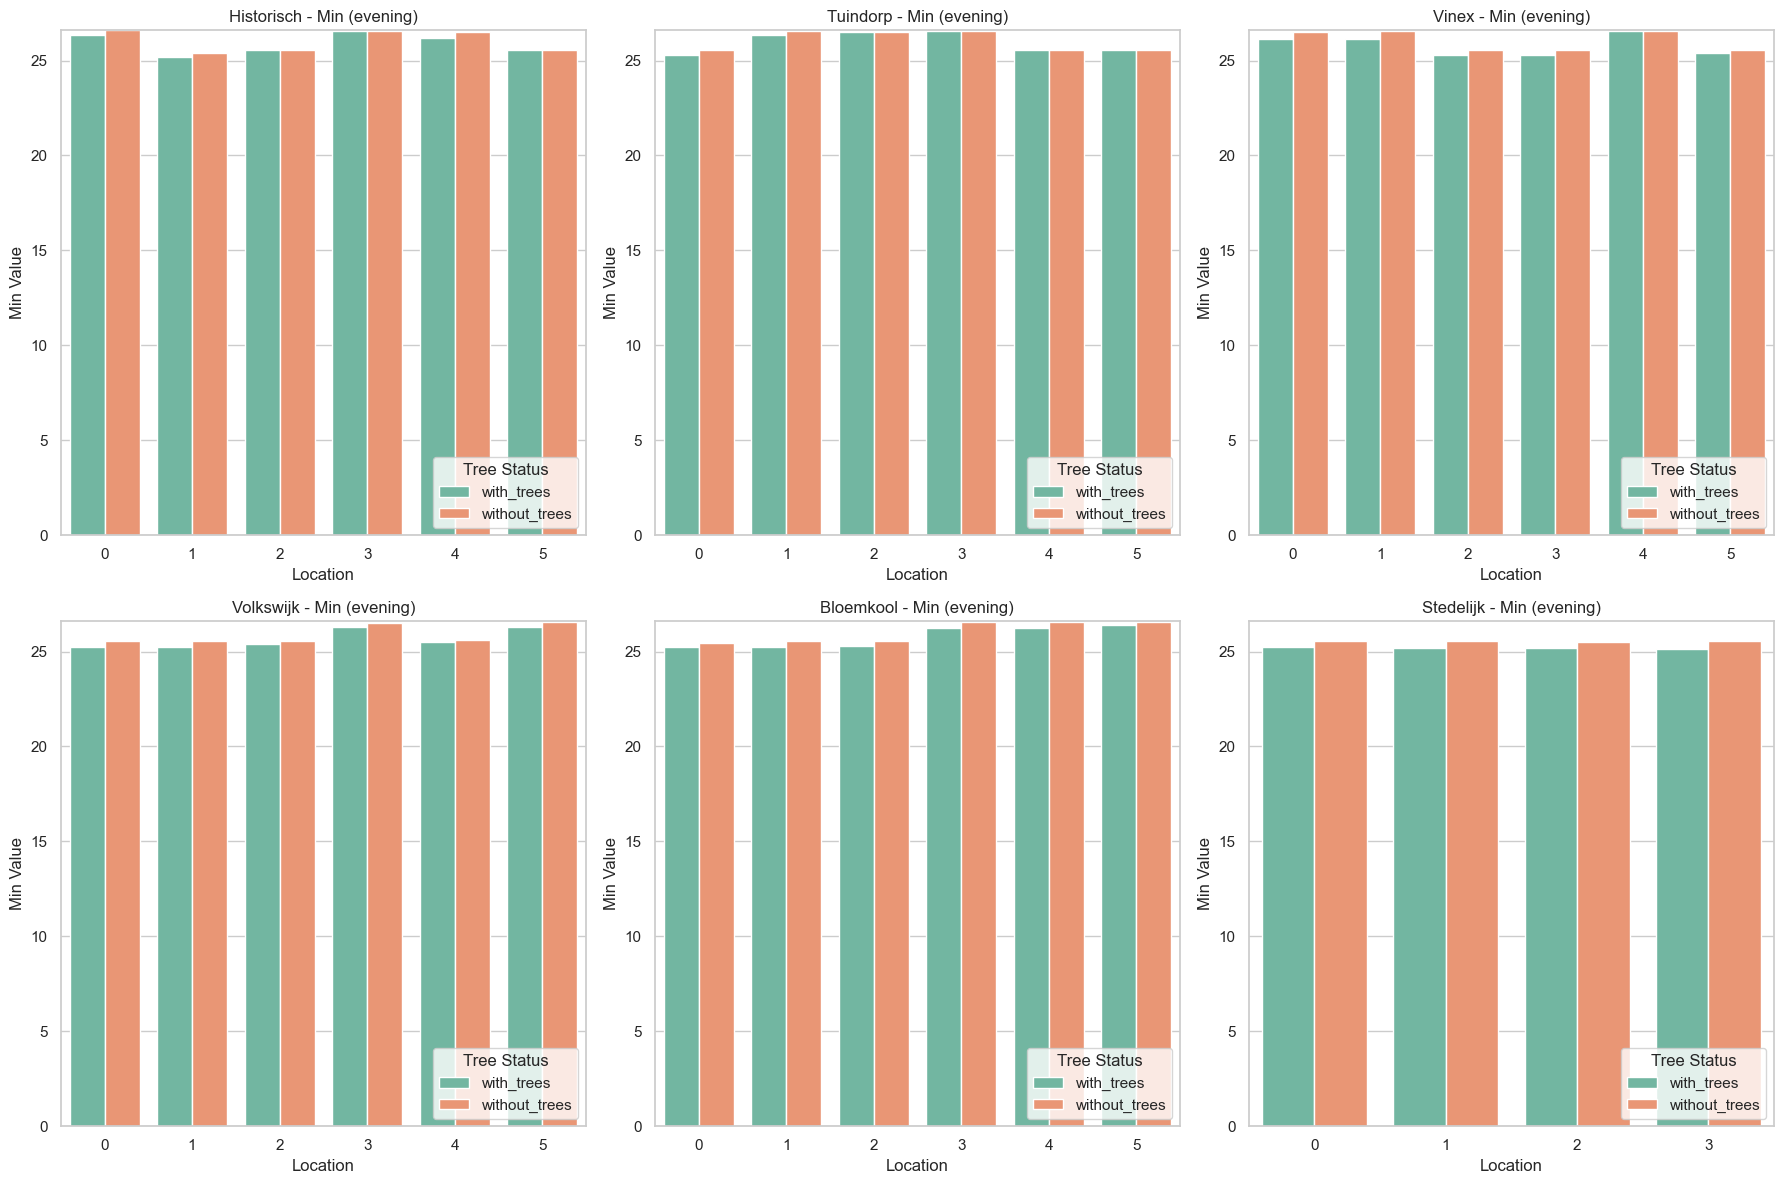

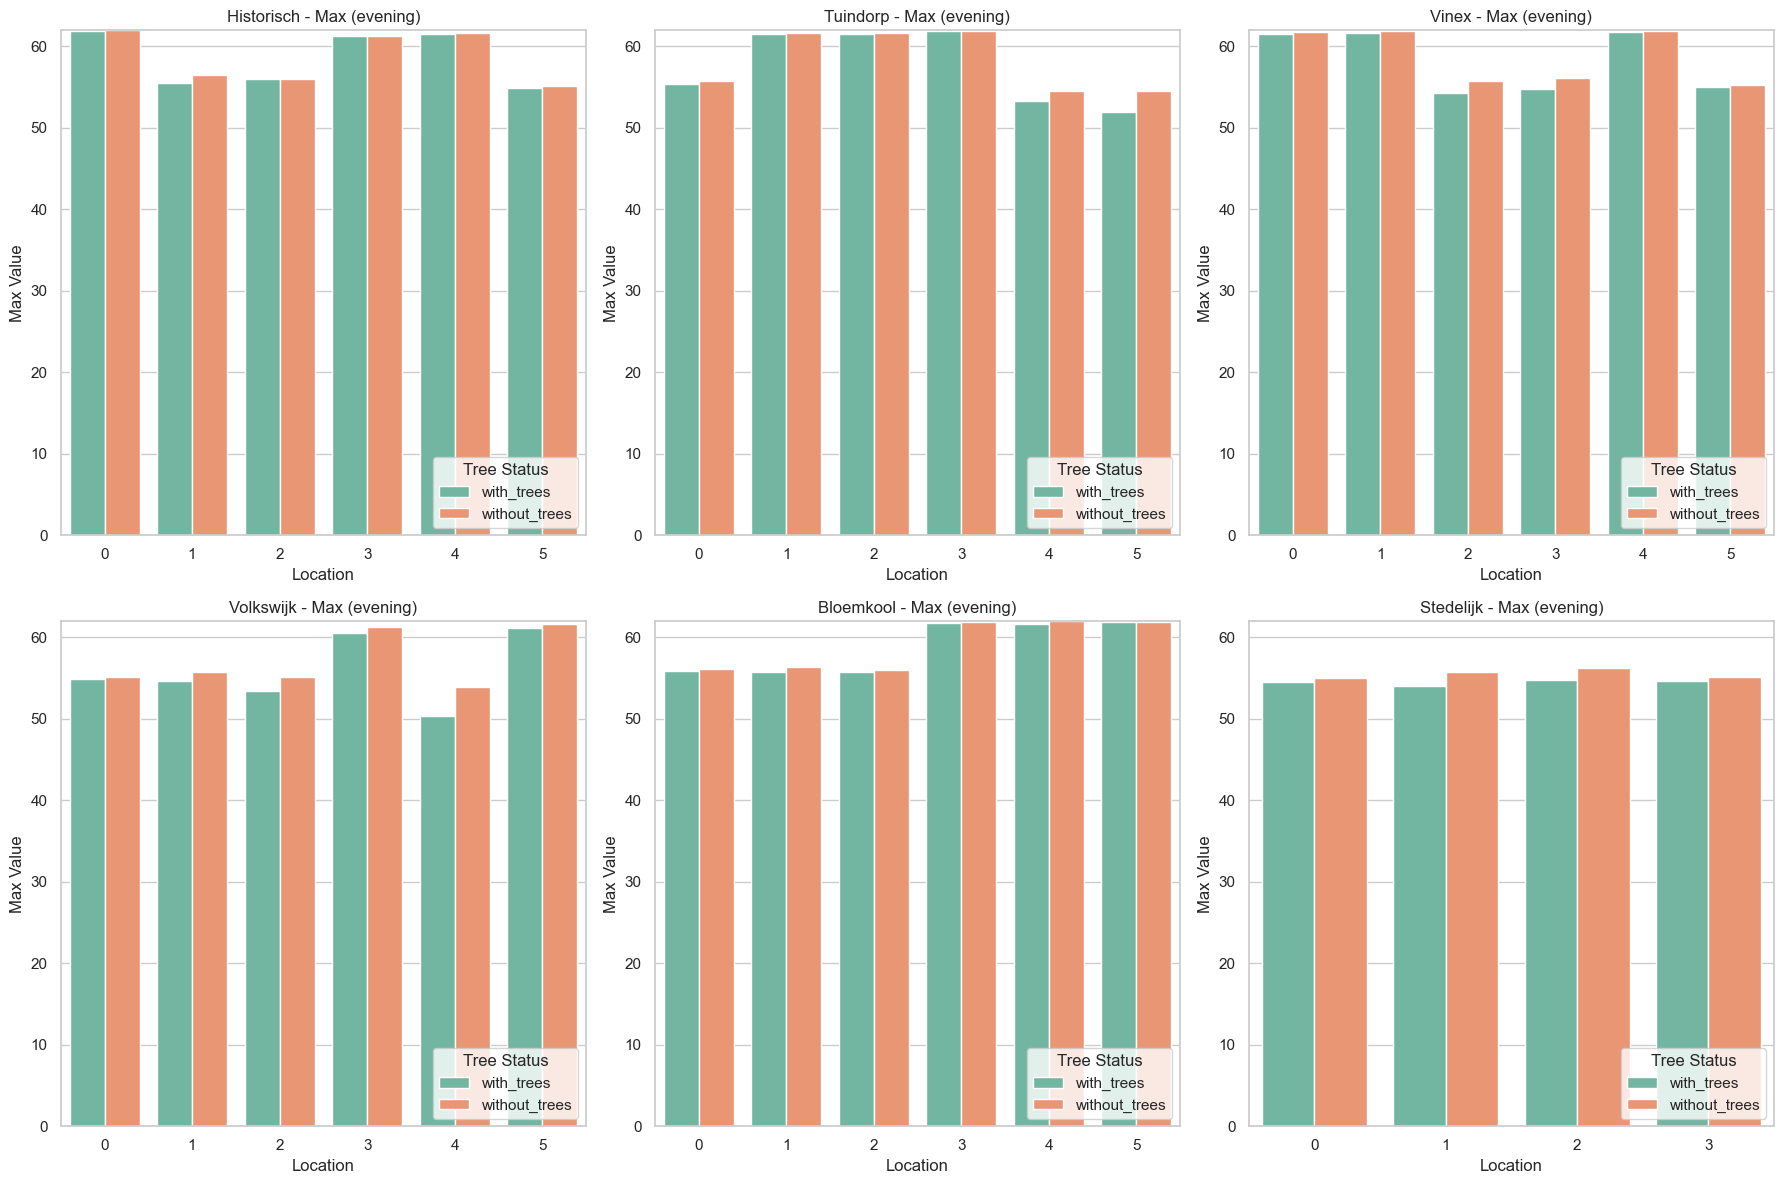

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Day type to filter
day = 'avg'

# Time periods to loop over
time_periods = ['morning', 'afternoon', 'evening']

# Stats to compare
stats = ['mean', 'median', 'min', 'max']

# Adjust for 'stedelijk' typology to only consider the first 4 locations
locs_to_plot = {typ: locs if typ != 'stedelijk' else locs[:4] for typ in typologies}

# Loop through each time period
for time_period in time_periods:
    for stat in stats:
        # --- Compute the global max value for this stat and time_period ---
        df_subset = df_all[
            (df_all['avg_or_ext'] == day) &
            (df_all['time'] == time_period)
        ]

        max_y = df_subset[stat].max()

        # Create a figure with 2 columns and 3 rows
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for idx, typ in enumerate(typologies):
            df_typology = df_subset[df_subset['typology'] == typ]

            plot_data = []
            locs_for_typology = locs_to_plot[typ]

            for loc in locs_for_typology:
                data_with_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == False)
                ][stat]

                data_without_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == True)
                ][stat]

                plot_data.append({
                    'location': loc,
                    'tree_status': 'with_trees',
                    'value': data_with_trees.mean() if not data_with_trees.empty else None
                })
                plot_data.append({
                    'location': loc,
                    'tree_status': 'without_trees',
                    'value': data_without_trees.mean() if not data_without_trees.empty else None
                })
            plot_df = pd.DataFrame(plot_data)
            ax = axes[idx]
            sns.barplot(
                x='location', y='value', hue='tree_status',
                data=plot_df, errorbar=None, palette="Set2",
                dodge=True, ax=ax
            )

            ax.set_title(f"{typ.capitalize()} - {stat.capitalize()} ({time_period})")
            ax.set_xlabel('Location')
            ax.set_ylabel(f'{stat.capitalize()} Value')
            ax.set_xticks(range(len(locs_for_typology)))
            ax.set_xticklabels([f'{i}' for i in locs_for_typology])
            ax.set_ylim(0, max_y)  # Apply shared y-axis limit
            ax.legend(title='Tree Status', loc='lower right', bbox_to_anchor=(1, 0))

        # Remove unused subplots if necessary
        for j in range(len(typologies), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()

        # Save the plot
        output_file = f"plots/{stat}_comparison_plot_{time_period}_{day}.png"
        plt.savefig(output_file)
        print(f"Saved plot as {output_file}")

        # plt.show()

[{'typology': 'historisch', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 37.699540222222225, 'without_trees_avg': 39.39394405555555, 'with_trees_std': 1.3715770016764832, 'without_trees_std': 1.6634717632958023}, {'typology': 'tuindorp', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 42.698731055555555, 'without_trees_avg': 44.95180916666667, 'with_trees_std': 1.343477588843353, 'without_trees_std': 1.2074392183676992}, {'typology': 'vinex', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 43.64906661111112, 'without_trees_avg': 45.90241316666667, 'with_trees_std': 1.5135436341964892, 'without_trees_std': 1.3142103741847535}, {'typology': 'volkswijk', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 39.858089, 'without_trees_avg': 41.87073388888889, 'with_trees_std': 1.4039100403360247, 'without_trees_std': 1.3504962105928404}, {'typology': 'bloemkool', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 42.68367372222222, 'without_trees_avg': 46.37658288888889, 

C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dat

Saved plot as plots/stat_typology_comparison_mean_avg.png


C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dat

Saved plot as plots/stat_typology_comparison_median_avg.png


C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dat

Saved plot as plots/stat_typology_comparison_min_avg.png


C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\141632416.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dat

Saved plot as plots/stat_typology_comparison_max_avg.png
      typology  stat       time  with_trees_avg  without_trees_avg  \
0   historisch  mean    morning       31.986930          34.012409   
1   historisch  mean  afternoon       49.769607          51.809533   
2   historisch  mean    evening       31.342083          32.359890   
3     tuindorp  mean    morning       35.113667          37.760116   
4     tuindorp  mean  afternoon       56.392269          58.570087   
..         ...   ...        ...             ...                ...   
91    tuindorp   max    overall       55.856030          56.376219   
92       vinex   max    overall       56.235883          56.612258   
93   volkswijk   max    overall       55.272915          55.971470   
94   bloemkool   max    overall       56.468713          56.672240   
95   stedelijk   max    overall       54.893129          55.412069   

    with_trees_std  without_trees_std  
0         0.724351           1.021052  
1         1.839967    

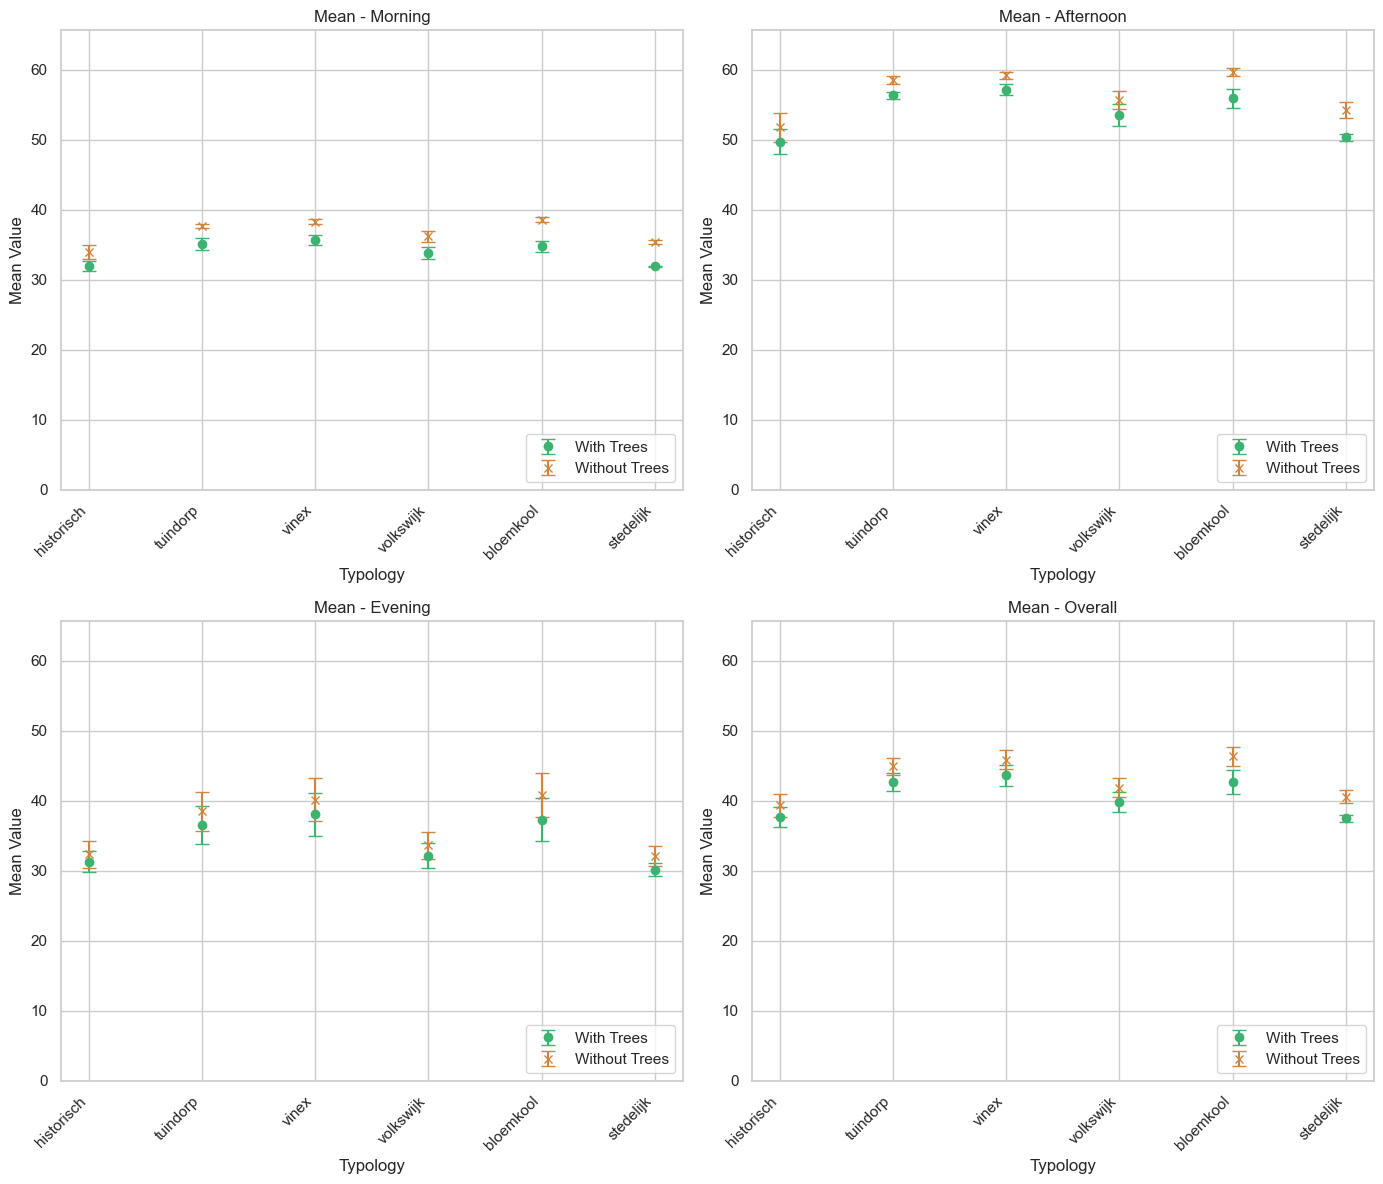

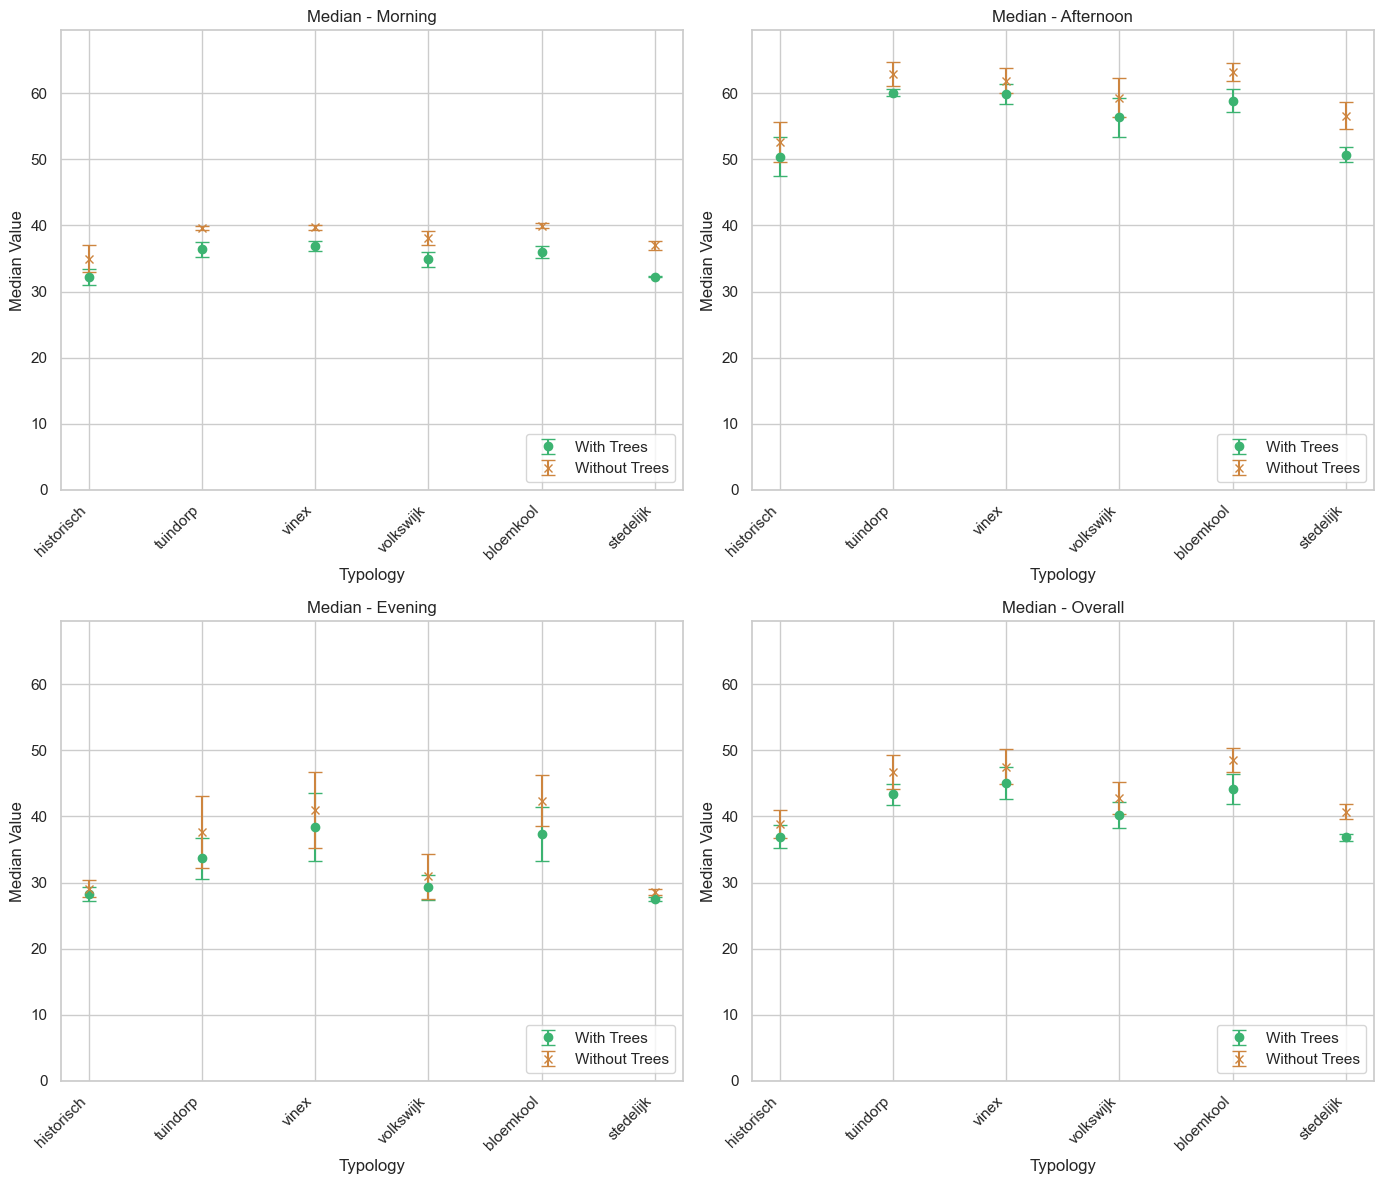

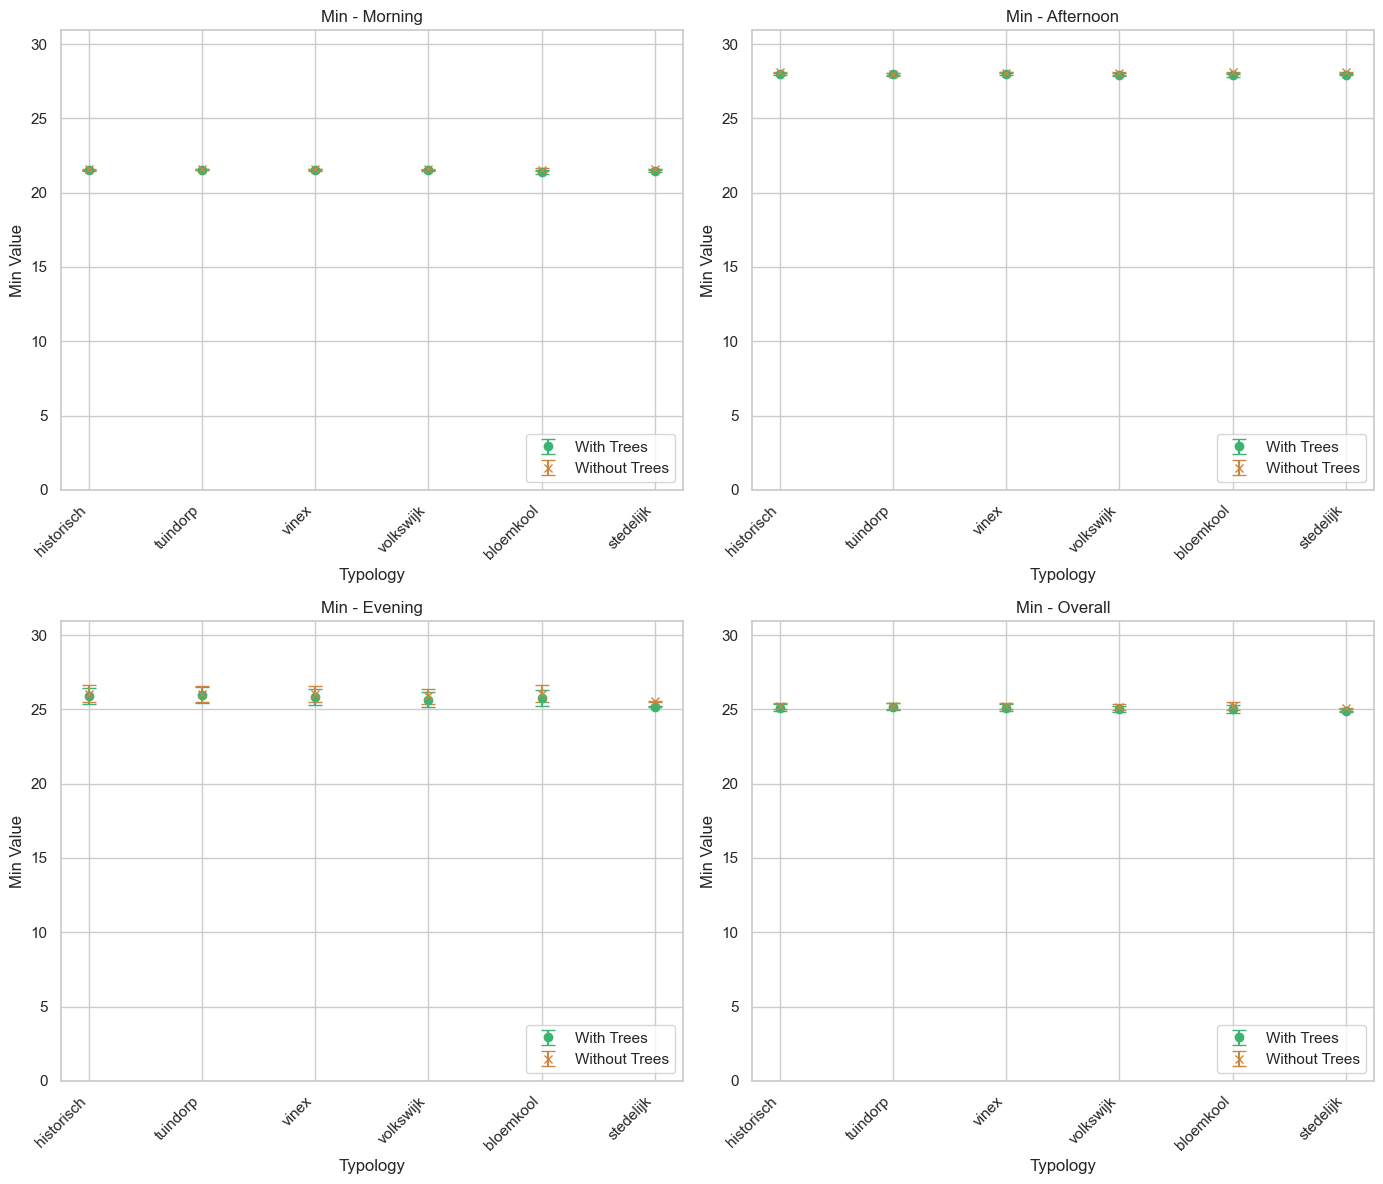

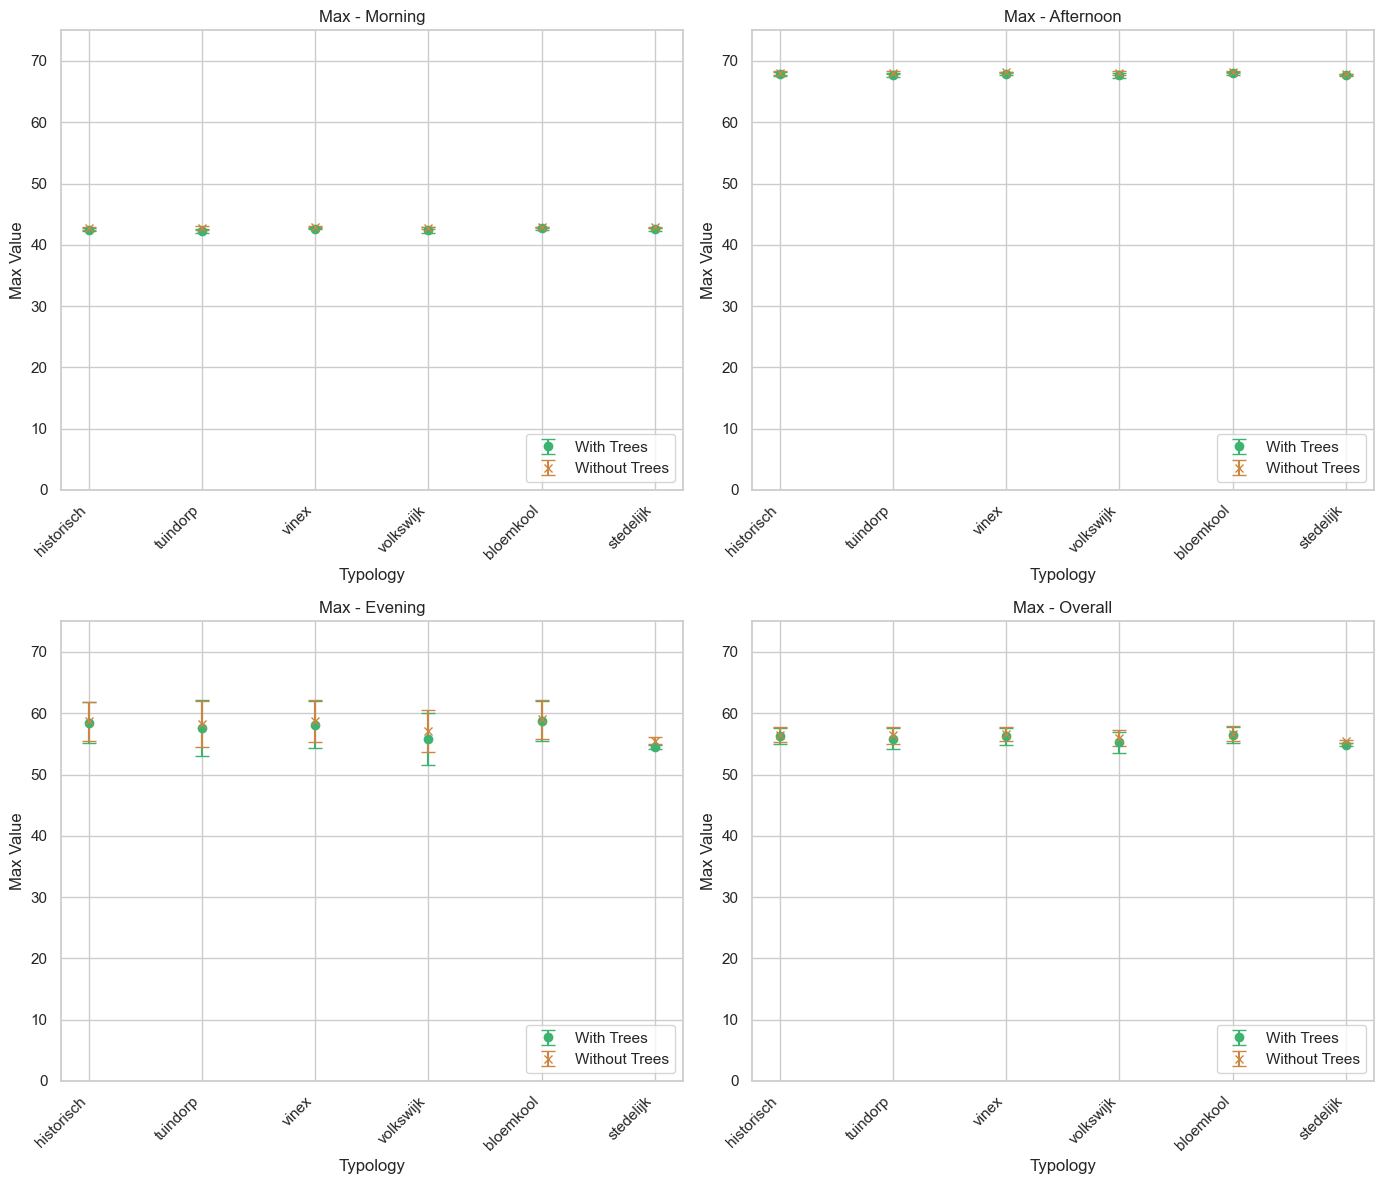

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Stats, time periods, typologies
stats = ['mean', 'median', 'min', 'max']
time_periods = ['morning', 'afternoon', 'evening']
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']

summary_data = []

# Compute summary values for each typology, time, and stat
for stat in stats:
    for typ in typologies:
        for time in time_periods:
            df_typology = df_all[
                (df_all['typology'] == typ) &
                (df_all['avg_or_ext'] == day) &
                (df_all['time'] == time)
            ]
            with_trees_vals = []
            without_trees_vals = []

            for loc in locs:
                data_with_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == False)
                ][stat]

                data_without_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == True)
                ][stat]

                with_trees_vals.append(data_with_trees.mean() if not data_with_trees.empty else None)
                without_trees_vals.append(data_without_trees.mean() if not data_without_trees.empty else None)

            avg_with = pd.Series(with_trees_vals).mean()
            std_with = pd.Series(with_trees_vals).std()
            avg_without = pd.Series(without_trees_vals).mean()
            std_without = pd.Series(without_trees_vals).std()

            summary_data.append({
                'typology': typ,
                'stat': stat,
                'time': time,
                'with_trees_avg': avg_with,
                'without_trees_avg': avg_without,
                'with_trees_std': std_with,
                'without_trees_std': std_without,
            })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Calculate the 'overall' values, which depend on the `day` parameter
average_rows = []
for stat in stats:
    for typ in typologies:
        # Subset the data based on the current typology and stat
        sub = summary_df[(summary_df['typology'] == typ) & (summary_df['stat'] == stat)]
        # For 'avg' day type: take the average of 'morning', 'afternoon', 'evening'
        # For 'ext' day type: do the same, but based on the specific day data
        sub_day = sub[sub['time'].isin(time_periods)]

        avg_with = sub_day['with_trees_avg'].mean()
        std_with = sub_day['with_trees_std'].mean()
        avg_without = sub_day['without_trees_avg'].mean()
        std_without = sub_day['without_trees_std'].mean()


        # Add an 'overall' row to the summary data
        average_rows.append({
            'typology': typ,
            'stat': stat,
            'time': 'overall',
            'with_trees_avg': avg_with,
            'without_trees_avg': avg_without,
            'with_trees_std': std_with,
            'without_trees_std': std_without
        })
print(average_rows)
summary_df = pd.concat([summary_df, pd.DataFrame(average_rows)], ignore_index=True)
print(summary_df)

# --- PLOTTING ---
for stat in stats:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    # Determine global y-axis limits for this stat
    stat_subset = summary_df[summary_df['stat'] == stat]
    all_values = pd.concat([
        stat_subset['with_trees_avg'],
        stat_subset['without_trees_avg']
    ])
    global_ymin = 0  # Always start from 0
    global_ymax = all_values.max() * 1.1  # Add 10% padding

    # Loop over time periods including the 'overall' calculated for the given `day` type
    for i, time in enumerate(time_periods + ['overall']):
        ax = axes[i]

        # Filter by 'overall' which is dependent on the `day` value
        if time == 'overall':
            data = stat_subset[stat_subset['time'] == 'overall']
        else:
            data = stat_subset[stat_subset['time'] == time]

        ax.errorbar(data['typology'], data['with_trees_avg'],
                    yerr=data['with_trees_std'], fmt='o', label='With Trees',
                    capsize=5, color='mediumseagreen', linestyle='None')

        ax.errorbar(data['typology'], data['without_trees_avg'],
                    yerr=data['without_trees_std'], fmt='x', label='Without Trees',
                    capsize=5, color='peru', linestyle='None')

        ax.set_title(f"{stat.capitalize()} - {time.capitalize()}")
        ax.set_xlabel("Typology")
        ax.set_ylabel(f"{stat.capitalize()} Value")
        ax.set_xticklabels(data['typology'], rotation=45, ha='right')
        ax.set_ylim(global_ymin, global_ymax)
        ax.legend(loc='lower right')

    plt.tight_layout()
    output_file = f"plots/stat_typology_comparison_{stat}_{day}.png"
    plt.savefig(output_file)
    print(f"Saved plot as {output_file}")
    # plt.show()
print(summary_df)
summary_df.to_csv(f"outputstats/summary_statistics_{day}.csv", index=False)
print(f"Saved summary DataFrame to summary_statistics_{day}.csv")

In [11]:
average_diff_data = []

for stat in stats:
    for typ in typologies:
        for time in time_periods:
            # Filter for current typology, time period, and extreme days
            df_typology = df_all[
                (df_all['typology'] == typ) &
                (df_all['avg_or_ext'] == day) &
                (df_all['time'] == time)
            ]

            location_diffs = []
            for loc in locs:
                data_with = df_typology[(df_typology['location'] == loc) & (df_typology['without_trees'] == False)][stat]
                data_without = df_typology[(df_typology['location'] == loc) & (df_typology['without_trees'] == True)][stat]

                if not data_with.empty and not data_without.empty:
                    diff = data_with.mean() - data_without.mean()
                    location_diffs.append(diff)

            avg_diff = pd.Series(location_diffs).mean() if location_diffs else None

            average_diff_data.append({
                'typology': typ,
                'stat': stat,
                'time': time,
                'average_difference': avg_diff
            })

# Add overall differences based on summary_df
for stat in stats:
    for typ in typologies:
        overall_row = summary_df[
            (summary_df['typology'] == typ) &
            (summary_df['stat'] == stat) &
            (summary_df['time'] == 'overall')
        ]

        if not overall_row.empty:
            avg_with = overall_row['with_trees_avg'].values[0]
            avg_without = overall_row['without_trees_avg'].values[0]
            avg_diff = avg_with - avg_without

            average_diff_data.append({
                'typology': typ,
                'stat': stat,
                'time': 'overall',
                'average_difference': avg_diff
            })

# Convert to DataFrame and sort
average_diff_df = pd.DataFrame(average_diff_data)
average_diff_df['time'] = pd.Categorical(average_diff_df['time'], categories=time_periods + ['overall'], ordered=True)
average_diff_df = average_diff_df.sort_values(by=['stat', 'typology', 'time'])

# Print results
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    print("\n--- AVERAGE TEMPERATURE IMPROVEMENT WITH TREES (per location) ---")
    print(average_diff_df)




--- AVERAGE TEMPERATURE IMPROVEMENT WITH TREES (per location) ---
      typology    stat       time  average_difference
66   bloemkool     max    morning           -0.133993
67   bloemkool     max  afternoon           -0.209359
68   bloemkool     max    evening           -0.267231
94   bloemkool     max    overall           -0.203527
54  historisch     max    morning           -0.245042
55  historisch     max  afternoon           -0.147407
56  historisch     max    evening           -0.219057
90  historisch     max    overall           -0.203835
69   stedelijk     max    morning           -0.344855
70   stedelijk     max  afternoon           -0.126117
71   stedelijk     max    evening           -1.085849
95   stedelijk     max    overall           -0.518941
57    tuindorp     max    morning           -0.464717
58    tuindorp     max  afternoon           -0.346252
59    tuindorp     max    evening           -0.749598
91    tuindorp     max    overall           -0.520189
60       vinex 

In [12]:
pivot_df = average_diff_df.pivot_table(
    index='typology',
    columns=['stat', 'time'],
    values='average_difference'
).round(2)  # round for LaTeX presentation

# Ensure all columns are present and in desired order
stats = ['mean', 'median', 'min', 'max']
time_order = ['morning', 'afternoon', 'evening', 'overall']
columns_order = [(s, t) for s in stats for t in time_order]
pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_tuples(columns_order))

# Generate LaTeX rows
latex_rows = ""
for typ in pivot_df.index:
    row = [typ] + [f"{pivot_df.loc[typ, (stat, time)]:.2f}" if pd.notna(pivot_df.loc[typ, (stat, time)]) else "-"
                   for stat in stats for time in time_order]
    latex_rows += " & ".join(row) + r" \\" + "\n"

print(latex_rows)

bloemkool & -3.81 & -3.77 & -3.50 & -3.69 & -3.99 & -4.31 & -4.97 & -4.42 & -0.14 & -0.19 & -0.28 & -0.20 & -0.13 & -0.21 & -0.27 & -0.20 \\
historisch & -2.03 & -2.04 & -1.02 & -1.69 & -2.83 & -2.22 & -0.81 & -1.96 & -0.07 & -0.15 & -0.15 & -0.12 & -0.25 & -0.15 & -0.22 & -0.20 \\
stedelijk & -3.47 & -3.91 & -1.97 & -3.12 & -4.76 & -5.90 & -1.11 & -3.92 & -0.11 & -0.15 & -0.37 & -0.21 & -0.34 & -0.13 & -1.09 & -0.52 \\
tuindorp & -2.65 & -2.18 & -1.93 & -2.25 & -3.20 & -2.85 & -3.95 & -3.34 & -0.02 & -0.04 & -0.08 & -0.05 & -0.46 & -0.35 & -0.75 & -0.52 \\
vinex & -2.61 & -2.06 & -2.10 & -2.25 & -2.84 & -1.95 & -2.62 & -2.47 & -0.04 & -0.08 & -0.24 & -0.12 & -0.27 & -0.26 & -0.61 & -0.38 \\
volkswijk & -2.40 & -2.16 & -1.48 & -2.01 & -3.21 & -2.98 & -1.66 & -2.62 & -0.07 & -0.12 & -0.24 & -0.14 & -0.38 & -0.40 & -1.31 & -0.70 \\



C:\Users\jessi\AppData\Local\Temp\ipykernel_13216\3030663603.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = average_diff_df.pivot_table(


Saved stacked bar plot for morning as: plots/tmrt_bin_stacked_morning_avg.png


<Figure size 1200x600 with 0 Axes>

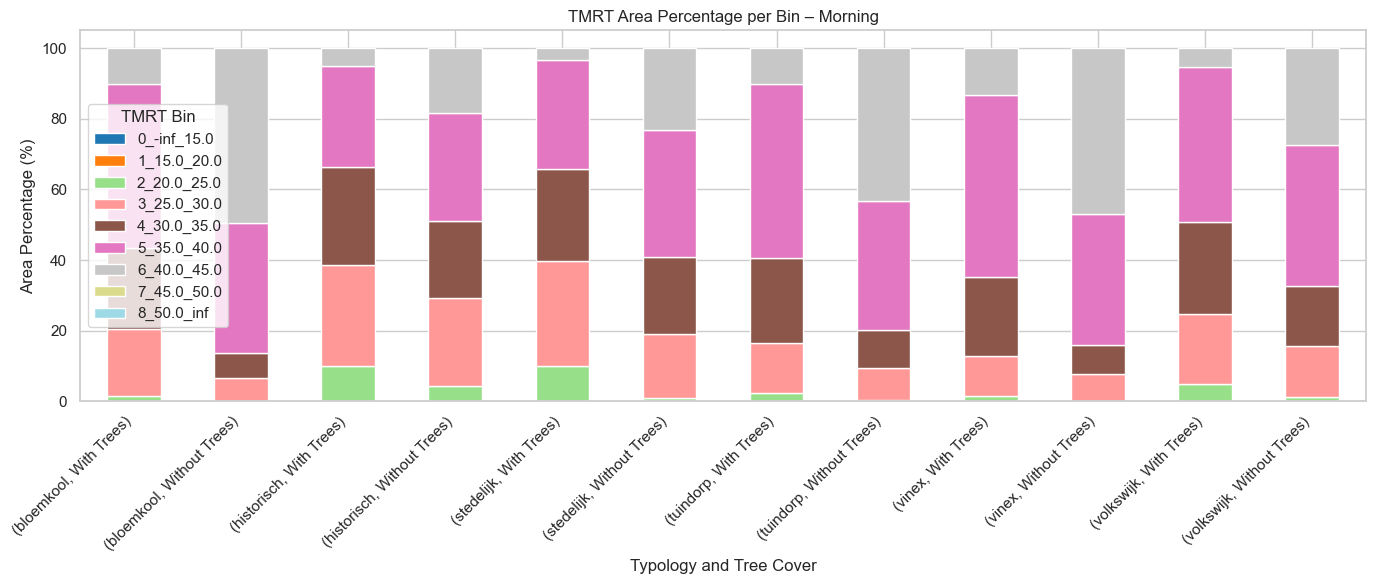

Saved stacked bar plot for afternoon as: plots/tmrt_bin_stacked_afternoon_avg.png


<Figure size 1200x600 with 0 Axes>

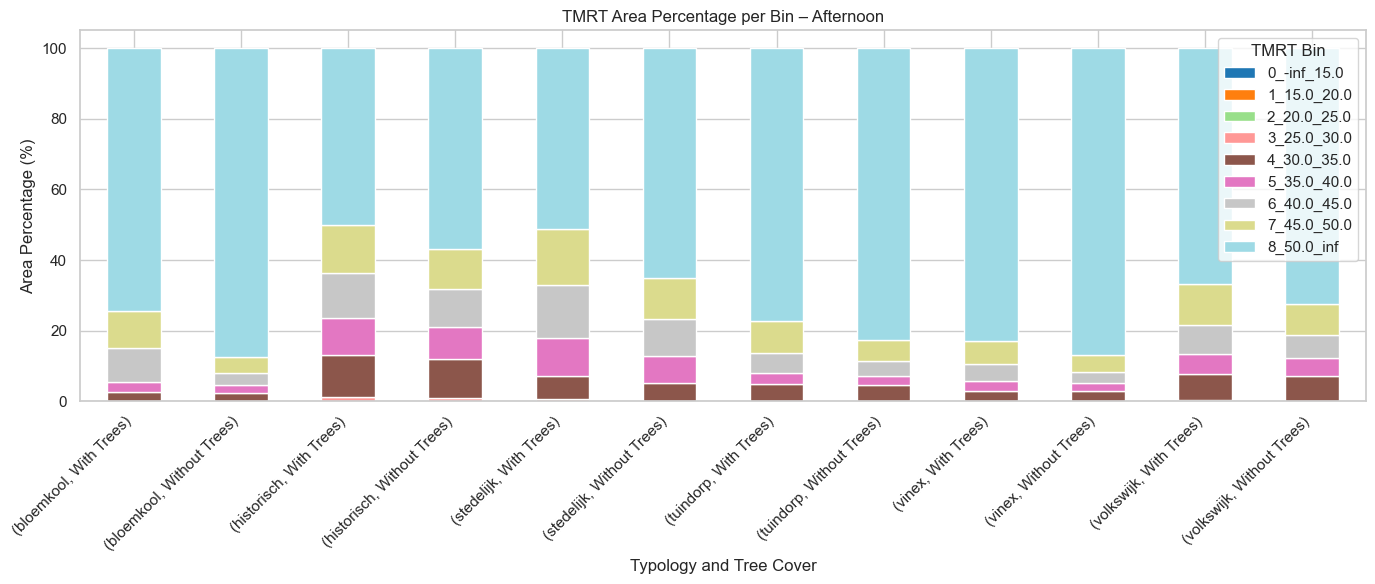

Saved stacked bar plot for evening as: plots/tmrt_bin_stacked_evening_avg.png


<Figure size 1200x600 with 0 Axes>

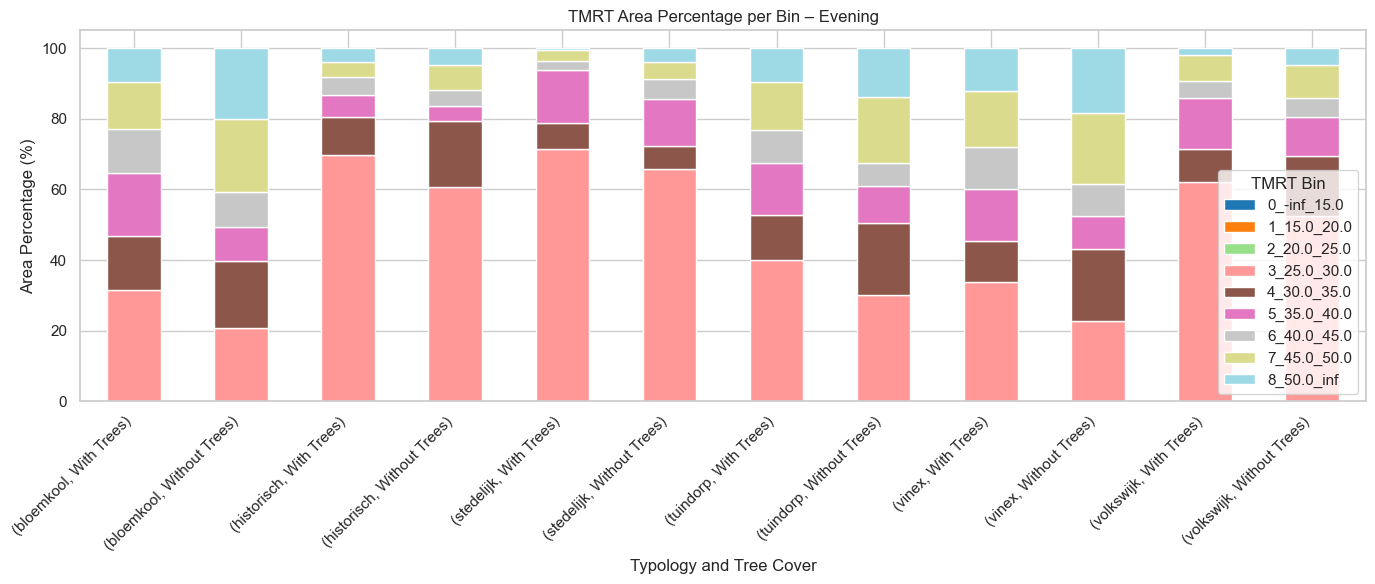

Saved stacked bar plot for overall as: plots/tmrt_bin_stacked_overall_avg.png


<Figure size 1200x600 with 0 Axes>

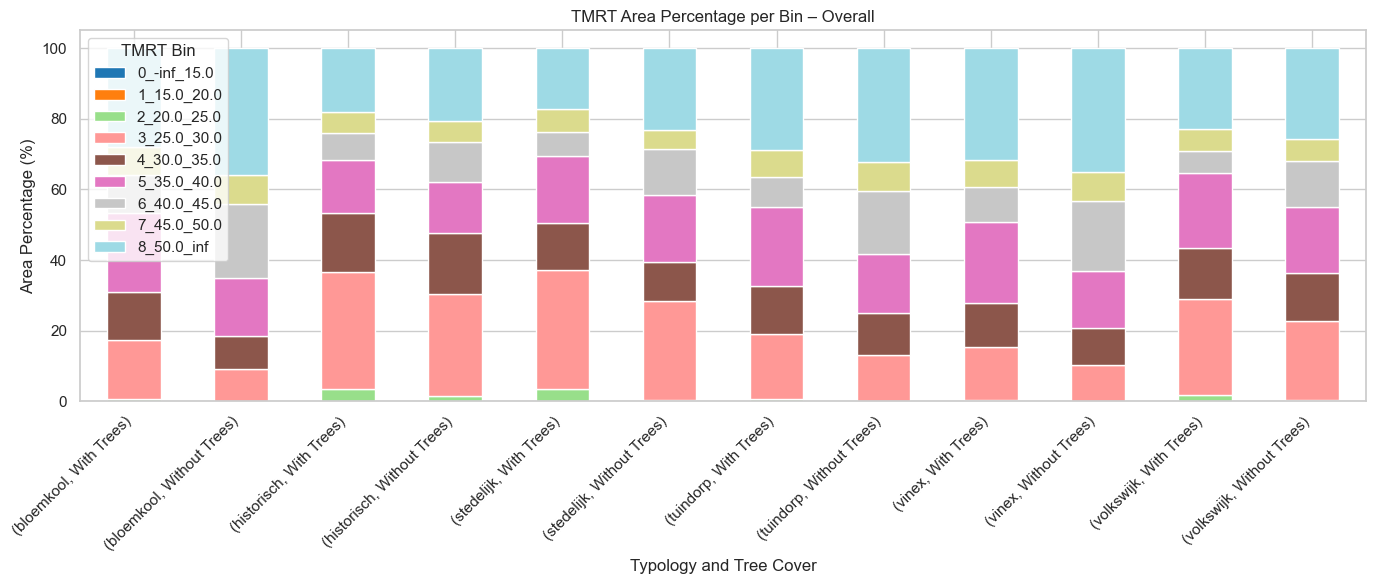

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
time_periods = ['morning', 'afternoon', 'evening', 'overall']
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']

# Extract percentage bin columns
percent_bin_cols = [col for col in df_all.columns if col.startswith('percent_bin_')]

# Create a list to collect summary data
summary_bins = []

for typ in typologies:
    for time in time_periods:
        for trees in [True, False]:  # True = without trees
            if time != 'overall':
                df_sub = df_all[
                    (df_all['typology'] == typ) &
                    (df_all['time'] == time) &
                    (df_all['without_trees'] == trees) &
                    (df_all['avg_or_ext'] == day)
                ]
            else:
                # For 'overall', average over morning, afternoon, evening
                df_sub = df_all[
                    (df_all['typology'] == typ) &
                    (df_all['time'].isin(['morning', 'afternoon', 'evening'])) &
                    (df_all['without_trees'] == trees) &
                    (df_all['avg_or_ext'] == day)
                ]
            if df_sub.empty:
                continue

            # Compute mean % per bin
            percent_means = df_sub[percent_bin_cols].mean()

            for col in percent_bin_cols:
                bin_label = col.replace('percent_bin_', '')
                summary_bins.append({
                    'typology': typ,
                    'time': time,
                    'without_trees': trees,
                    'bin': bin_label,
                    'percent': percent_means[col]
                })

# Create summary DataFrame
df_bins_summary = pd.DataFrame(summary_bins)

# Map boolean to label
df_bins_summary['Tree Cover'] = df_bins_summary['without_trees'].map({False: 'With Trees', True: 'Without Trees'})

# Plotting
sns.set(style='whitegrid')
for time in time_periods:
    plt.figure(figsize=(12, 6))
    plot_data = df_bins_summary[df_bins_summary['time'] == time]

    # Pivot for stacked bar
    pivot_df = plot_data.pivot_table(
        index=['typology', 'Tree Cover'],
        columns='bin',
        values='percent',
        fill_value=0
    )

    # Sort bin order naturally if needed
    pivot_df = pivot_df.sort_index()

    # Create bar plot
    ax = pivot_df.plot(
        kind='bar',
        stacked=True,
        colormap='tab20',
        figsize=(14, 6)
    )

    plt.title(f"TMRT Area Percentage per Bin – {time.capitalize()}")
    plt.ylabel("Area Percentage (%)")
    plt.xlabel("Typology and Tree Cover")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="TMRT Bin")
    plt.tight_layout()

    outpath = f"plots/tmrt_bin_stacked_{time}_{day}.png"
    plt.savefig(outpath)
    print(f"Saved stacked bar plot for {time} as: {outpath}")
    plt.show()
